### Zone dispatch

In [ ]:
pip install jupyter

: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils import get_data
from utils import tech_order, tech_colors, config
from datetime import datetime, timedelta
from pytz import timezone
import scienceplots
import os

plt.style.use(['science','ieee'])
pd.options.display.float_format = '{:,.2f}'.format

: 

In [98]:
m12_ticks=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

In [12]:
def read_scenarios(file_name):
    input_scenarios=pd.read_csv(file_name, index_col=False)
    scenario = list(input_scenarios['scenario'])
    short_names = dict(input_scenarios[['scenario', 'short_name']].values)
    order= dict(input_scenarios[['short_name', 'order']].values)
    return scenario, short_names, order

In [13]:
scenario, short_names, order = read_scenarios("input_scenarios_wecc.csv")

folder_to_save_results='paper/'

#Check if the directory exists. If not, then create the directory.
if not os.path.exists(folder_to_save_results):
    os.makedirs(folder_to_save_results)

In [10]:
def stacked_dispatch(sc, zone, time_zone, start_date, end_date, transmission):
    time_1=datetime.strptime(str(start_date), '%Y %m %d %H').replace(tzinfo=timezone(time_zone))
    time_2=datetime.strptime(str(end_date), '%Y %m %d %H').replace(tzinfo=timezone(time_zone))

    #Get energy dispatch
    dpch= get_data(sc, "dispatch.csv", usecols=["generation_project", "timestamp", "gen_tech", "gen_load_zone", "tp_weight_in_year_hrs", "DispatchGen_MW"])
    dpch.replace({"scenario": short_names}, inplace=True)
    dpch=dpch.loc[dpch.gen_load_zone.isin(zone)]
    dpch['DispatchGen_MWh']=dpch['DispatchGen_MW']*dpch['tp_weight_in_year_hrs']

    #Get charging energy
    stg= get_data(sc, "storage_dispatch.csv")
    stg.replace({"scenario": short_names},inplace=True)
    stg=stg.loc[stg.load_zone.isin(zone)]
    stg.rename({'timepoint': 'timestamp', 'load_zone':'gen_load_zone', 'ChargeMW': 'DispatchGen_MW'}, axis=1, inplace=True)
    stg.drop(['datetime', 'DischargeMW', 'StateOfCharge'], axis=1, inplace=True)
    stg['gen_tech']='Battery_Storage_Charge'
    stg['tech_map']='Storage (C)'
    stg=pd.merge(left=stg, right=dpch[['generation_project','timestamp', 'tp_weight_in_year_hrs', 'scenario']], on=['generation_project','timestamp', 'scenario'], how='inner', copy='False')
    stg['DispatchGen_MWh']=stg['DispatchGen_MW']*stg['tp_weight_in_year_hrs']
    stg['DispatchGen_MW']=stg['DispatchGen_MW']*-1
    stg['DispatchGen_MWh']=stg['DispatchGen_MWh']*-1

    z_dpch=pd.concat([dpch, stg])

    if transmission==1:
        tx_dispatch = get_data(sc, "transmission_dispatch.csv", usecols=['load_zone_from', 'load_zone_to', 'timestamp','transmission_dispatch'])
        tx_dispatch.replace({"scenario": short_names}, inplace=True)

        txs = get_data(sc, "transmission_lines.csv", fpath='inputs')
        txs.replace({"scenario": short_names}, inplace=True)
        txs = txs[['trans_lz1', 'trans_lz2', 'scenario']]
        txs = txs.loc[((txs.trans_lz1.isin(zone)) ^ (txs.trans_lz2.isin(zone)))]
        txs_copy=txs.copy() #Duplicate the table to have NM in the sending zone and receiving zone
        txs_copy.rename(columns={'trans_lz1':'trans_lz2', 'trans_lz2':'trans_lz1'}, inplace=True)
        txs=pd.concat([txs,txs_copy])
        txs.reset_index(inplace=True, drop=True)
        txs.rename(columns={'trans_lz1': 'load_zone_from', 'trans_lz2': 'load_zone_to'}, inplace=True)

        tx_flow=pd.merge(txs, tx_dispatch, how='inner', on=['load_zone_from', 'load_zone_to', 'scenario']) 
        tx_flow['ex_im_sign']=np.where(tx_flow['load_zone_from'].isin(zone), -1, 1)
        tx_flow['tech_map']=np.where(tx_flow['ex_im_sign'] == -1, 'Exports', 'Imports') #-1 if it is exporting

        time=dpch[['timestamp', 'scenario', 'tp_weight_in_year_hrs']].copy()
        time.drop_duplicates(inplace=True)

        tx_flow=pd.merge(tx_flow, time, how='left', on=['timestamp', 'scenario'])
        tx_flow.rename({'transmission_dispatch':'DispatchGen_MW'}, axis=1, inplace=True)
        tx_flow['DispatchGen_MW'] = tx_flow['DispatchGen_MW']*tx_flow['ex_im_sign']
        tx_flow['DispatchGen_MWh']=tx_flow['DispatchGen_MW']*tx_flow['tp_weight_in_year_hrs']
        tx_flow['gen_load_zone']=np.where(tx_flow['load_zone_from'].isin(zone), tx_flow['load_zone_from'], tx_flow['load_zone_to'])
        tx_flow['generation_project']=tx_flow['load_zone_from']+"---"+tx_flow['load_zone_to']
        tx_flow['gen_tech']=tx_flow['tech_map']
        tx_flow.drop(['load_zone_from', 'load_zone_to', 'ex_im_sign'], axis=1, inplace=True)
        z_dpch=pd.concat([z_dpch, tx_flow])

    z_dpch["timestamp"]=pd.to_datetime(z_dpch["timestamp"], format='%Y%m%d%H', utc=True)
    z_dpch["timestamp"]=z_dpch["timestamp"].dt.tz_convert(time_zone)
    z_dpch['DispatchGen_GWh']=z_dpch['DispatchGen_MWh']*10**(-3)

    a_1=z_dpch.copy()

    a_1['hour']=a_1['timestamp'].dt.hour  #Create a column that has the hour of the timestamp
    a_1=a_1[(time_1 <= a_1.timestamp) & (a_1.timestamp < time_2)]  

    daily_dispatch_source= a_1.pivot_table(index="hour", columns='tech_map', values="DispatchGen_GWh", aggfunc=np.sum)
    #Add the technologies that are in tech order but have dispatch zero. This serves to order the stacked area plot according to the tech order vector
    for k in tech_order:
        if not k in daily_dispatch_source.columns:
            daily_dispatch_source[k]=0

    daily_dispatch_source = daily_dispatch_source / ((time_2 - time_1).days) #Daily average

    #New dataframe
    full_daily_dispatch=daily_dispatch_source.copy()
    full_daily_dispatch=full_daily_dispatch[tech_order]

    #Replicate the rows to fill up the hours of the time interval. For example, if the time interval comprises 4 hours, then copy the result of 
    #hour and replicate them.
    #Number of hours of a time block
    time_range=4 
    for h in list(daily_dispatch_source.index):
        for k in range(0,time_range):
            full_daily_dispatch.loc[h+k,:]=full_daily_dispatch.loc[h,:]

    #If the hour index is greater than 24, the row is reindex with h-24, and then it is dropped.
    for h in list(full_daily_dispatch.index):
        if h>=24:
            full_daily_dispatch.loc[h-24,:]=full_daily_dispatch.loc[h,:]
            full_daily_dispatch.drop(index=h, inplace=True)

    #Sort the dataframe to have it chronologic
    full_daily_dispatch.sort_index(inplace=True)

    b_1=z_dpch.copy()
    b_1['month']=b_1['timestamp'].dt.month  #Create a column that has the month of the timestamp
    monthly_dispatch= b_1.pivot_table(index="month", columns='tech_map', values="DispatchGen_GWh", aggfunc=np.sum)
    for k in tech_order:
        if not k in monthly_dispatch.columns:
            monthly_dispatch[k]=0
            
    monthly_dispatch=monthly_dispatch[tech_order]
    return full_daily_dispatch, monthly_dispatch

In [ ]:
scenario, short_names, order = read_scenarios("input_scenarios_wecc.csv")

In [123]:
hours_per_year = 8766

timepoints = get_data(ultralow_coordinated, "timepoints.csv", fpath='inputs')
timepoints.columns= timepoints .columns.str.lower()
timepoints.rename(columns={'timepoint_id': 'timepoint'}, inplace=True)
timepoints = timepoints .replace({"ultralow_coordinated": short_names})

timeseries = get_data(ultralow_coordinated, "timeseries.csv", fpath='inputs')
timeseries.columns= timeseries .columns.str.lower()
timeseries = timeseries .replace({"ultralow_coordinated": short_names})

periods = get_data(ultralow_coordinated, "periods.csv", fpath='inputs')
periods.columns= periods .columns.str.lower()
periods.rename(columns={'investment_period': 'ts_period'}, inplace=True)
periods = periods .replace({"ultralow_coordinated": short_names})

time_info=pd.merge(left=timeseries,right=timepoints, on=['timeseries', 'ultralow_coordinated'])
time_info=pd.merge(left=time_info,right=periods , on=['ultralow_coordinated', 'ts_period'])

time_info['tp_weight']=time_info['ts_duration_of_tp']*time_info['ts_scale_to_period']

period_info=time_info.pivot_table(index=['ultralow_coordinated','ts_period'], values='tp_weight',aggfunc=np.sum )
period_info.reset_index(inplace=True)
period_info.rename(columns={'tp_weight': 'hours_in_period'}, inplace=True)
period_info = pd.merge(left=period_info, right = periods, on=['ultralow_coordinated', 'ts_period'])
period_info['err_plain'] = (period_info['period_end'] - period_info['period_start'])*hours_per_year - period_info['hours_in_period']
period_info['err_add_one'] =  (period_info['period_end'] + 1 - period_info['period_start'])*hours_per_year - period_info['hours_in_period']
period_info.loc[:, 'add_one_to_period_end_rule']= period_info.apply(lambda x: 1 if np.absolute(x['err_add_one'])<np.absolute(x['err_plain']) else 0, axis=1)
period_info['period_length_years'] = period_info['period_end'] - period_info['period_start'] + period_info['add_one_to_period_end_rule']



exception
timestamp in column


KeyError: 'ultralow_coordinated'

In [14]:
ultralow_coordinated="baseline_pverde_ldes_5"
medium_coordinated="baseline_pverde_ldes_60"
base_coordinated="baseline_pverde"

ultralow_ca_islanded="baseline_pverde_ca_ldes_5"
medium_ca_islanded="baseline_pverde_ca_ldes_60"
base_ca_islanded="baseline_pverde_ca"

ca_zones=['CA_IID', 'CA_LADWP', 'CA_PGE_BAY', 'CA_PGE_CEN', 'CA_PGE_N', 'CA_PGE_S', 'CA_SCE_CEN', 'CA_SCE_S','CA_SCE_SE','CA_SCE_VLY','CA_SDGE', 'CA_SMUD', 'MEX_BAJA']
start_date="2035 06 01 00"
end_date="2035 06 30 00"
transmission=1

ca_daily_ultralow = stacked_dispatch(ultralow_coordinated, ca_zones, 'US/Pacific', start_date, end_date, transmission)[0]
ca_daily_medium = stacked_dispatch(medium_coordinated, ca_zones, 'US/Pacific', start_date, end_date, transmission)[0]
ca_daily_base = stacked_dispatch(base_coordinated, ca_zones, 'US/Pacific', start_date, end_date, transmission)[0]

ca_is_daily_ultralow = stacked_dispatch(ultralow_ca_islanded, ca_zones, 'US/Pacific', start_date, end_date, 0)[0]
ca_is_daily_medium = stacked_dispatch(medium_ca_islanded, ca_zones, 'US/Pacific', start_date, end_date, 0)[0]
ca_is_daily_base = stacked_dispatch(base_ca_islanded, ca_zones, 'US/Pacific', start_date, end_date, 0)[0]


exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column


In [110]:
ca_monthly_ultralow = stacked_dispatch(ultralow_coordinated, ca_zones, 'US/Pacific', start_date, end_date, transmission)[1]/1000
ca_monthly_medium = stacked_dispatch(medium_coordinated, ca_zones, 'US/Pacific', start_date, end_date, transmission)[1]/1000
ca_monthly_base = stacked_dispatch(base_coordinated, ca_zones, 'US/Pacific', start_date, end_date, transmission)[1]/1000

ca_is_monthly_ultralow = stacked_dispatch(ultralow_ca_islanded, ca_zones, 'US/Pacific', start_date, end_date, 0)[1]/1000
ca_is_monthly_medium = stacked_dispatch(medium_ca_islanded, ca_zones, 'US/Pacific', start_date, end_date, 0)[1]/1000
ca_is_monthly_base = stacked_dispatch(base_ca_islanded, ca_zones, 'US/Pacific', start_date, end_date, 0)[1]/1000

exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column


In [48]:
ultralow_coordinated="baseline_pverde_ldes_5"
medium_coordinated="baseline_pverde_ldes_120"
base_coordinated="baseline_pverde"

ultralow_nm_islanded="baseline_pverde_islanded_ldes_5"
medium_nm_islanded="baseline_pverde_islanded_ldes_120"
base_nm_islanded="baseline_pverde_islanded"
nm_zones=['NM_N']

nm_daily_ultralow = stacked_dispatch(ultralow_coordinated, nm_zones, 'US/Mountain', start_date, end_date, transmission)[0]
nm_daily_medium = stacked_dispatch(medium_coordinated, nm_zones, 'US/Mountain', start_date, end_date, transmission)[0]
nm_daily_base = stacked_dispatch(base_coordinated, nm_zones, 'US/Mountain', start_date, end_date, transmission)[0]

nm_is_daily_ultralow = stacked_dispatch(ultralow_nm_islanded, nm_zones, 'US/Mountain', start_date, end_date, 0)[0]
nm_is_daily_medium = stacked_dispatch(medium_nm_islanded, nm_zones, 'US/Mountain', start_date, end_date, 0)[0]
nm_is_daily_base = stacked_dispatch(medium_nm_islanded, nm_zones, 'US/Mountain', start_date, end_date, 0)[0]

exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column


In [49]:
nm_monthly_ultralow = stacked_dispatch(ultralow_coordinated, nm_zones, 'US/Mountain', start_date, end_date, transmission)[1]
nm_monthly_medium = stacked_dispatch(medium_coordinated, nm_zones, 'US/Mountain', start_date, end_date, transmission)[1]
nm_monthly_base = stacked_dispatch(base_coordinated, nm_zones, 'US/Mountain', start_date, end_date, transmission)[1]

nm_is_monthly_ultralow = stacked_dispatch(ultralow_nm_islanded, nm_zones, 'US/Mountain', start_date, end_date, 0)[1]
nm_is_monthly_medium = stacked_dispatch(medium_nm_islanded, nm_zones, 'US/Mountain', start_date, end_date, 0)[1]
nm_is_monthly_base = stacked_dispatch(base_nm_islanded, nm_zones, 'US/Mountain', start_date, end_date, 0)[1]

exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column
exception
timestamp in column


### California

(0.0, 23.0)

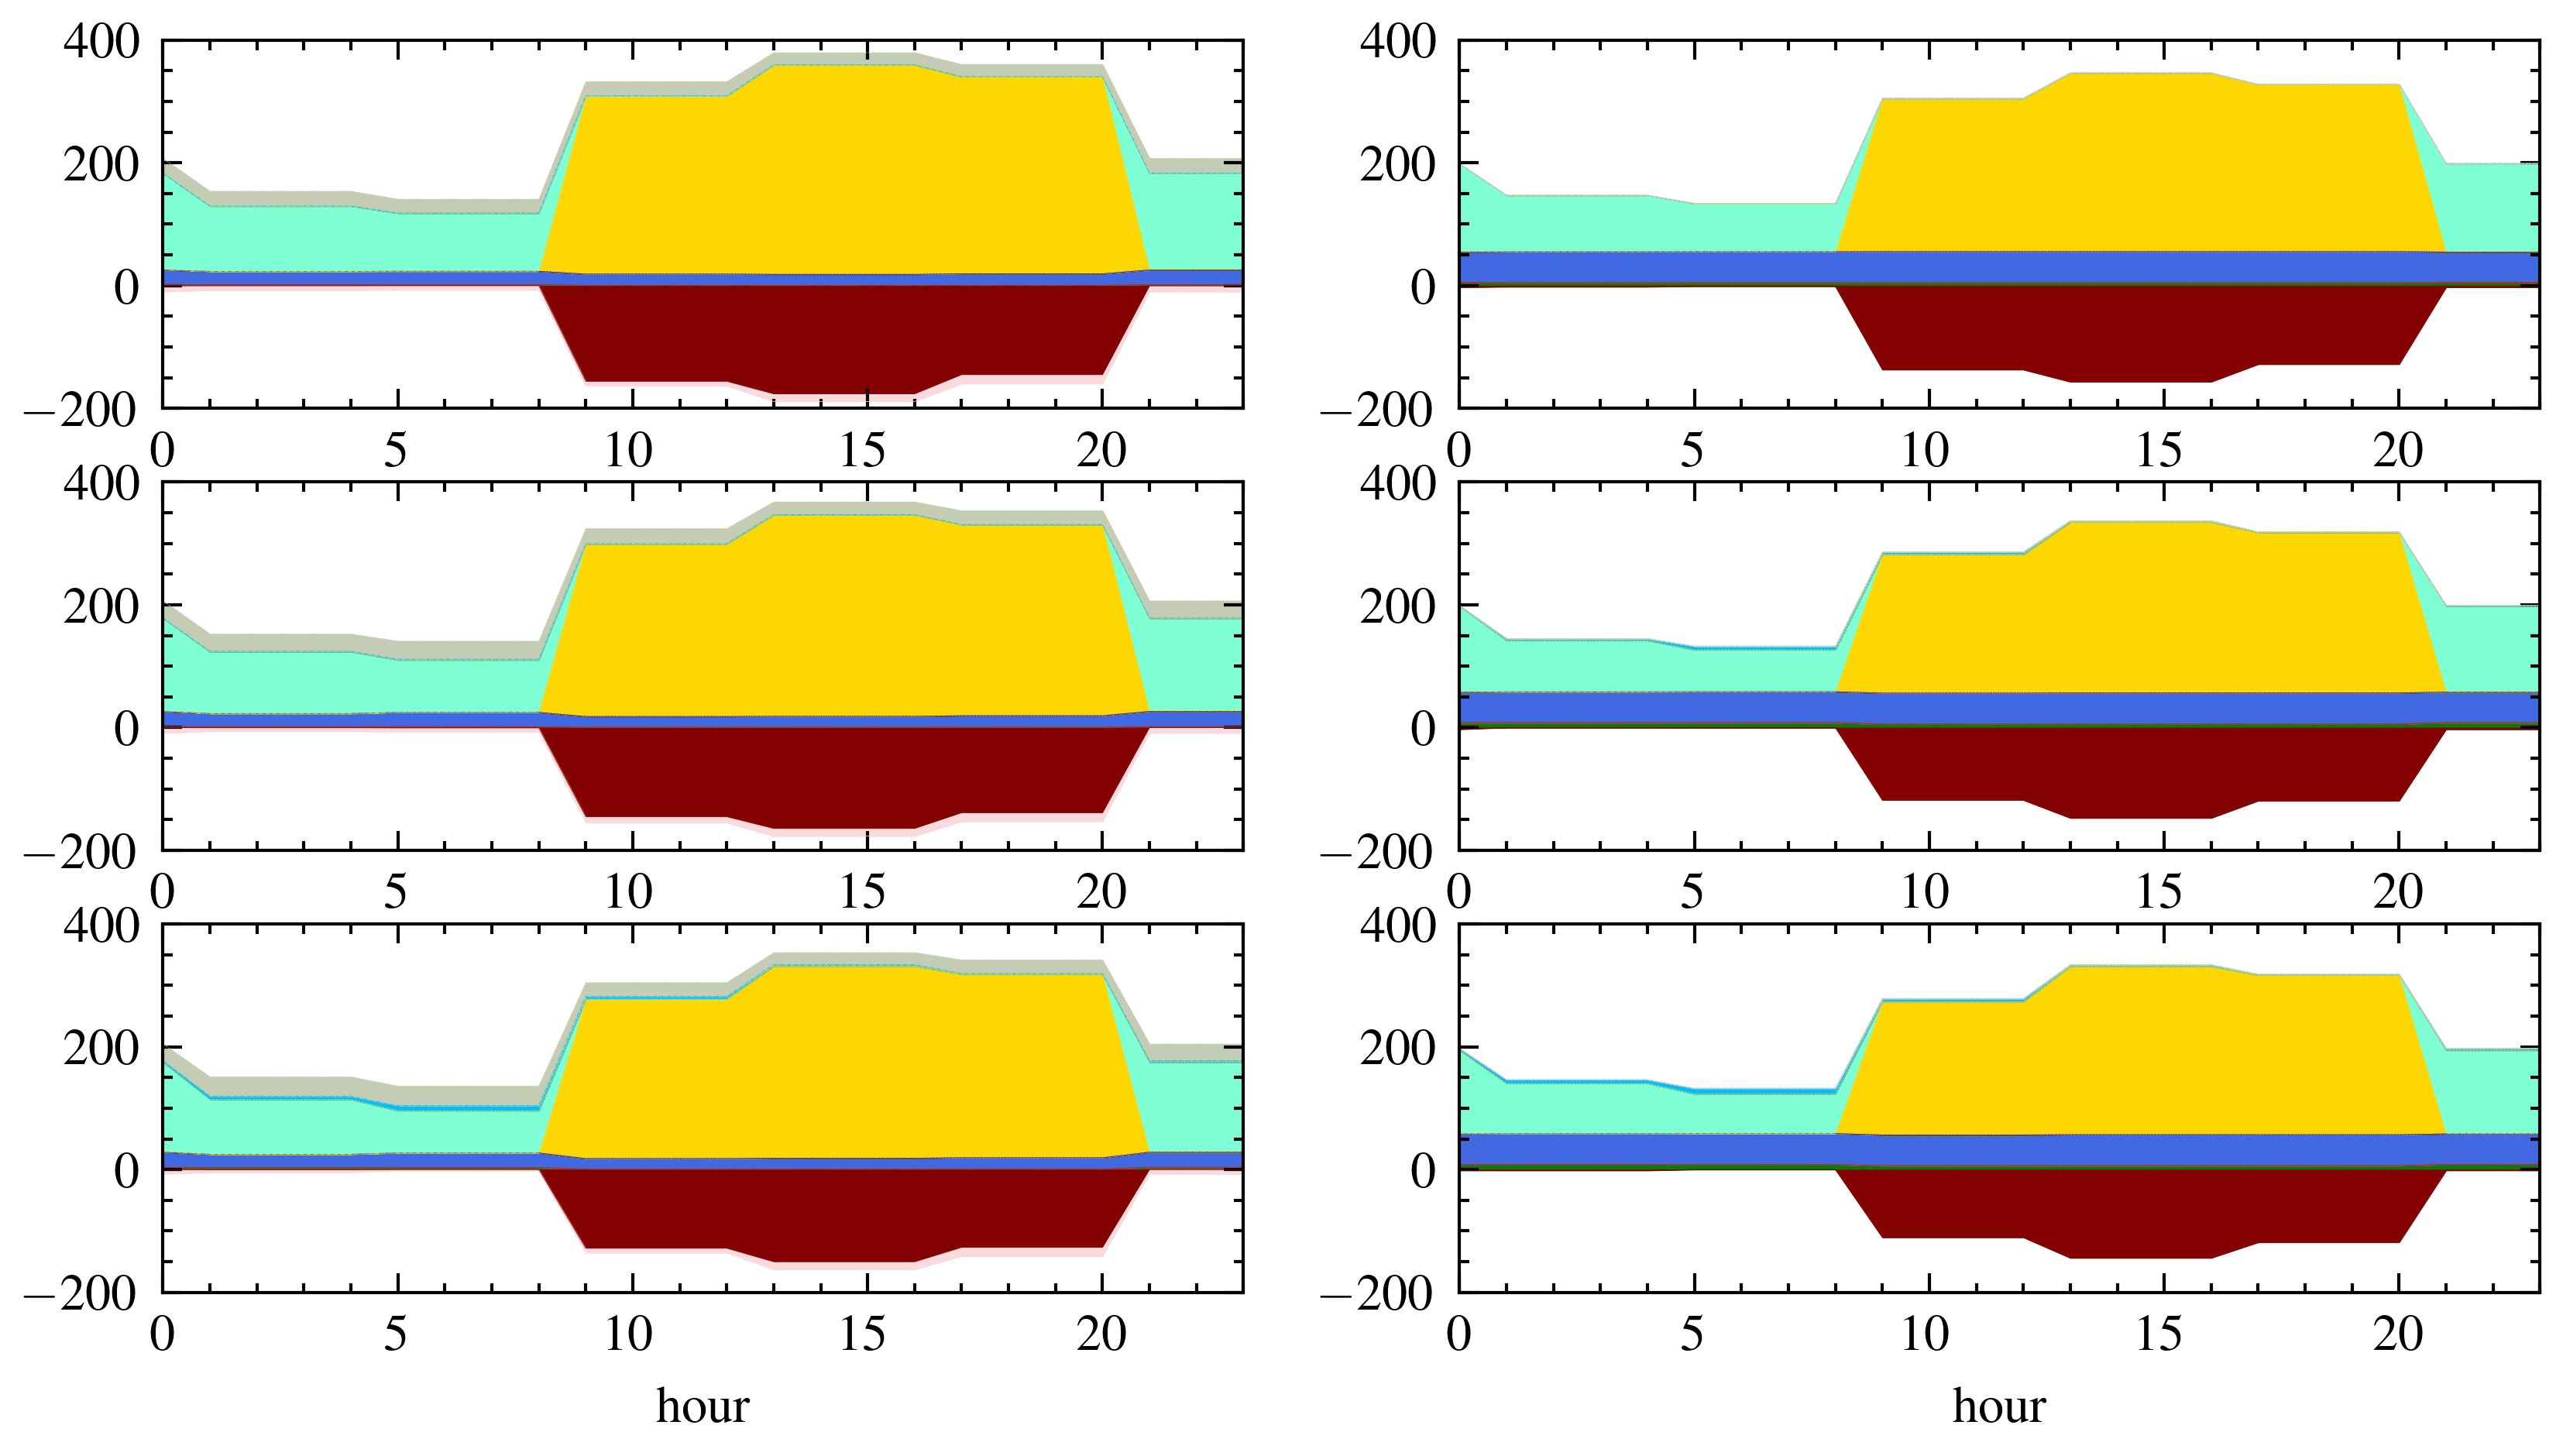

In [7]:
figure_name = "Generation capacity coordinated vs islanded.pdf"

x_label_name="Storage energy capacity cost (USD/kWh)"
y_label_name="Capacity (\%)"
x_ticks=np.arange(0, 181, 20)

fig, ((ax11, ax12), (ax21, ax22), (ax31, ax32)) = plt.subplots(nrows=3, ncols=2, figsize=(6.6,3.5))

ax11 = ca_daily_ultralow[tech_order].plot.area(stacked=True,ax=ax11, color=tech_colors, rot=0, lw=0.1,legend=None)
ax11.set_ylim(-200,400)
ax11.set_xlim(ca_daily_ultralow.index[0], ca_daily_ultralow.index[-1])

ax12 = ca_is_daily_ultralow[tech_order].plot.area(stacked=True,ax=ax12, color=tech_colors, rot=0, lw=0.1,legend=None)
ax12.set_ylim(-200,400)
ax12.set_xlim(ca_is_daily_ultralow.index[0], ca_is_daily_ultralow.index[-1])

ax21 = ca_daily_medium[tech_order].plot.area(stacked=True,ax=ax21, color=tech_colors, rot=0, lw=0.1, legend=None)
ax21.set_ylim(-200,400)
ax21.set_xlim(ca_daily_medium.index[0], ca_daily_medium.index[-1])

ax22 = ca_is_daily_medium[tech_order].plot.area(stacked=True,ax=ax22, color=tech_colors, rot=0, lw=0.1, legend=None)
ax22.set_ylim(-200,400)
ax22.set_xlim(ca_is_daily_medium.index[0], ca_is_daily_medium.index[-1])

ax31 = ca_daily_base[tech_order].plot.area(stacked=True,ax=ax31, color=tech_colors, rot=0, lw=0.1, legend=None)
ax31.set_ylim(-200,400)
ax31.set_xlim(ca_daily_base.index[0], ca_daily_base.index[-1])

ax32 = ca_is_daily_base[tech_order].plot.area(stacked=True,ax=ax32, color=tech_colors, rot=0, lw=0.1, legend=None)
ax32.set_ylim(-200,400)
ax32.set_xlim(ca_is_daily_base.index[0], ca_is_daily_base.index[-1])



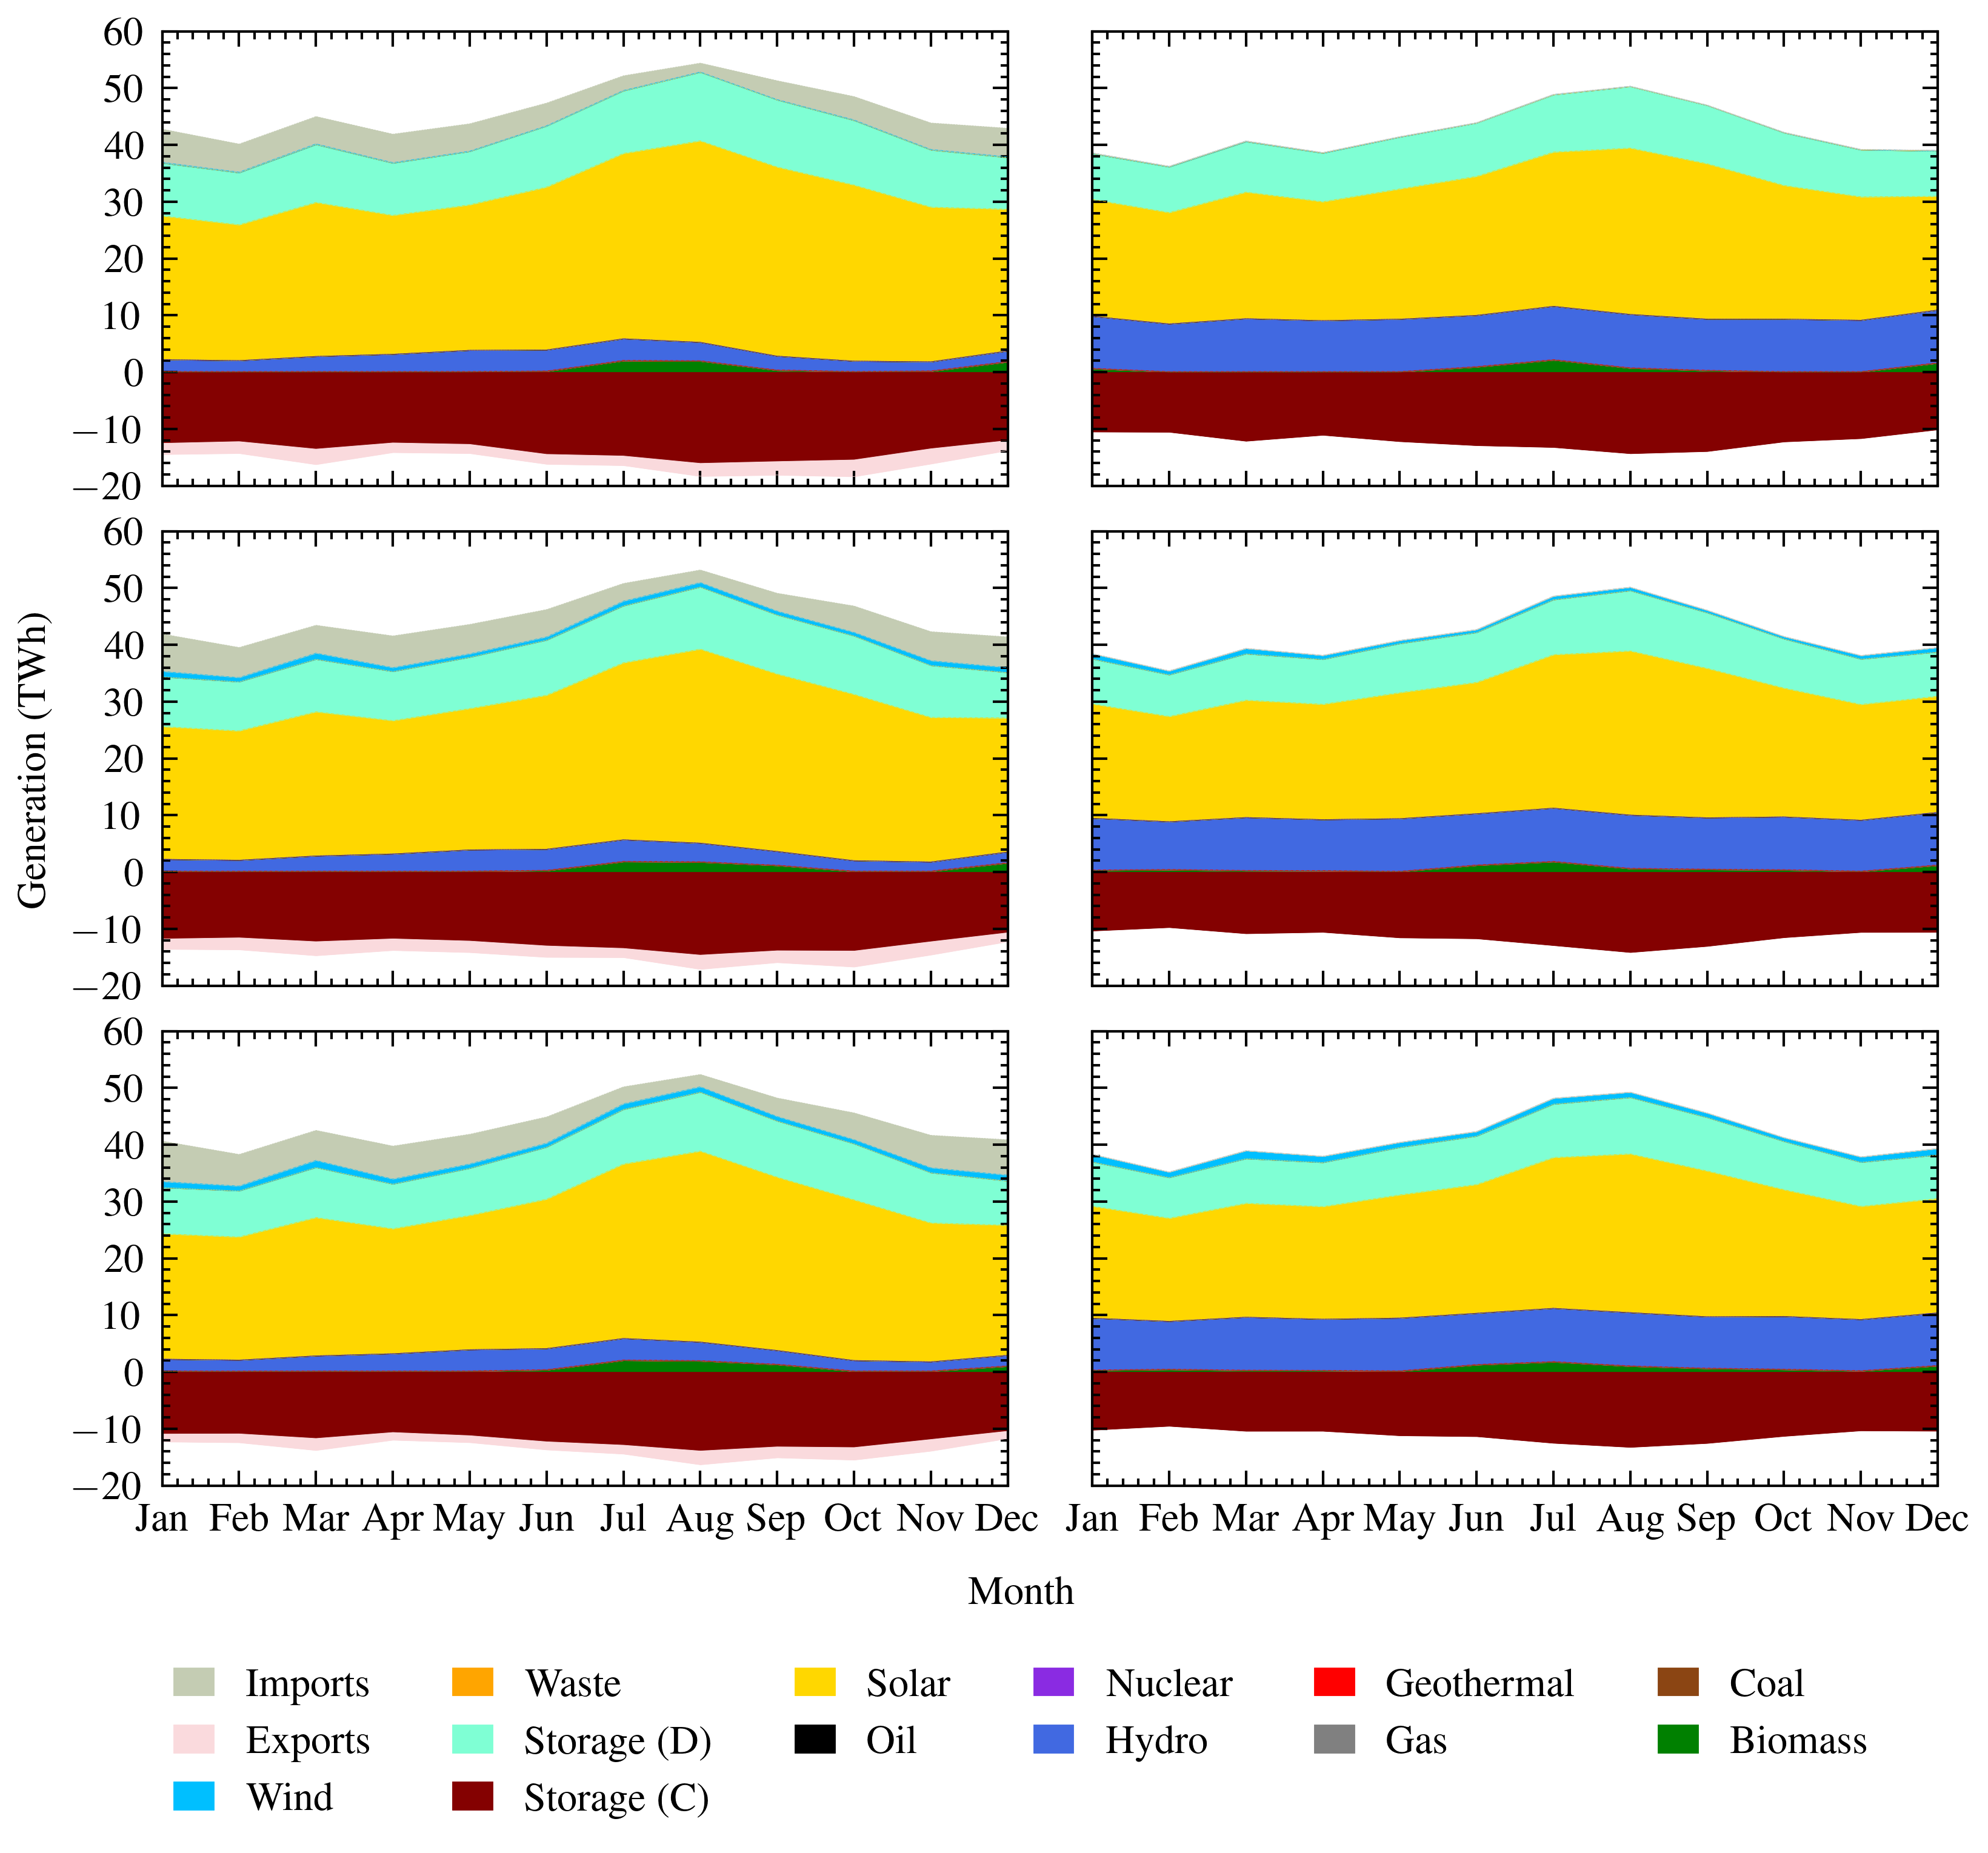

In [121]:
y_lower=-20
y_upper=60
y_ticks=np.arange(-20, 61, 10)
y_label_name = 'Generation (TWh)'
x_label_name = 'Month'

#IEEE sizes: 3.3, 2.5
fig, ((ax11, ax12), (ax21, ax22), (ax31, ax32)) = plt.subplots(nrows=3, ncols=2, figsize=(6.3,5))
plt.subplots_adjust(left  = 0.125,  # the left side of the subplots of the figure
                    right = 0.9 ,   # the right side of the subplots of the figure
                    bottom = 0.1,   # the bottom of the subplots of the figure
                    top = 0.9,      # the top of the subplots of the figure
                    wspace = 0.1,   # the amount of width reserved for blank space between subplots
                    hspace = 0.1)   # the amount of height reserved for white space between subplots

ax11 = ca_monthly_ultralow[tech_order].plot.area(stacked=True,ax=ax11, color=tech_colors, rot=0, lw=0.1,legend=None)
ax11.set_ylim(y_lower,y_upper)
ax11.set_yticks(y_ticks)
ax11.set_xlim(ca_monthly_ultralow.index[0], ca_monthly_ultralow.index[-2])
ax11.set_xticks(np.linspace(1,12,12), m12_ticks,  rotation=0)
plt.setp(ax11.get_xticklabels(), visible=False)
ax11.set_xlabel('')

ax12 = ca_is_monthly_ultralow[tech_order].plot.area(stacked=True,ax=ax12, color=tech_colors, rot=0, lw=0.1,legend=None)
ax12.set_ylim(y_lower,y_upper)
ax12.set_yticks(y_ticks)
ax12.set_xlim(ca_is_monthly_ultralow.index[0], ca_is_monthly_ultralow.index[-2])
ax12.set_xticks(np.linspace(1,12,12), m12_ticks,  rotation=0)
plt.setp(ax12.get_yticklabels(), visible=False)
plt.setp(ax12.get_xticklabels(), visible=False)
ax12.set_xlabel('')

ax21 = ca_monthly_medium[tech_order].plot.area(stacked=True,ax=ax21, color=tech_colors, rot=0, lw=0.1, legend=None)
ax21.set_ylim(y_lower,y_upper)
ax21.set_yticks(y_ticks)
ax21.set_xlim(ca_monthly_medium.index[0], ca_monthly_medium.index[-2])
ax21.set_xticks(np.linspace(1,12,12), m12_ticks,  rotation=0)
plt.setp(ax21.get_xticklabels(), visible=False)
ax21.set_xlabel('')

ax22 = ca_is_monthly_medium[tech_order].plot.area(stacked=True,ax=ax22, color=tech_colors, rot=0, lw=0.1, legend=None)
ax22.set_ylim(y_lower,y_upper)
ax22.set_yticks(y_ticks)
ax22.set_xlim(ca_is_monthly_medium.index[0], ca_is_monthly_medium.index[-2])
ax22.set_xticks(np.linspace(1,12,12), m12_ticks,  rotation=0)
ax22.set_xlabel('')
plt.setp(ax22.get_xticklabels(), visible=False)
plt.setp(ax22.get_yticklabels(), visible=False)

ax31 = ca_monthly_base[tech_order].plot.area(stacked=True,ax=ax31, color=tech_colors, rot=0, lw=0.1, legend=None)
ax31.set_ylim(y_lower,y_upper)
ax31.set_yticks(y_ticks)
ax31.set_xticks(np.linspace(1,12,12), m12_ticks,  rotation=0)
ax31.set_xlim(ca_is_monthly_base.index[0], ca_monthly_base.index[-1])
ax31.set_xlabel('')


ax32 = ca_is_monthly_base[tech_order].plot.area(stacked=True,ax=ax32, color=tech_colors, rot=0, lw=0.1, legend=None)
ax32.set_ylim(y_lower,y_upper)
ax32.set_yticks(y_ticks)
ax32.set_ylim(y_lower,y_upper)
ax32.set_xticks(np.linspace(1,12,12), m12_ticks,  rotation=0)
ax32.set_xlim(ca_is_monthly_base.index[0], ca_is_monthly_base.index[-1])
plt.setp(ax32.get_yticklabels(), visible=False)
ax32.set_xlabel('')

handles, labels = ax32.get_legend_handles_labels()

fig.text(0.07, 0.5, y_label_name, ha='center', va='center', rotation='vertical')
fig.text(0.5, 0.04, x_label_name, ha='center', va='center', rotation='horizontal')

fig.legend(
    handles[::-1],
    labels[::-1],
    bbox_to_anchor=(0.5,0.02),
    loc="upper center",
    ncol=6,
    handlelength=1,
    edgecolor="black",
    facecolor="white",
)

### New Mexico

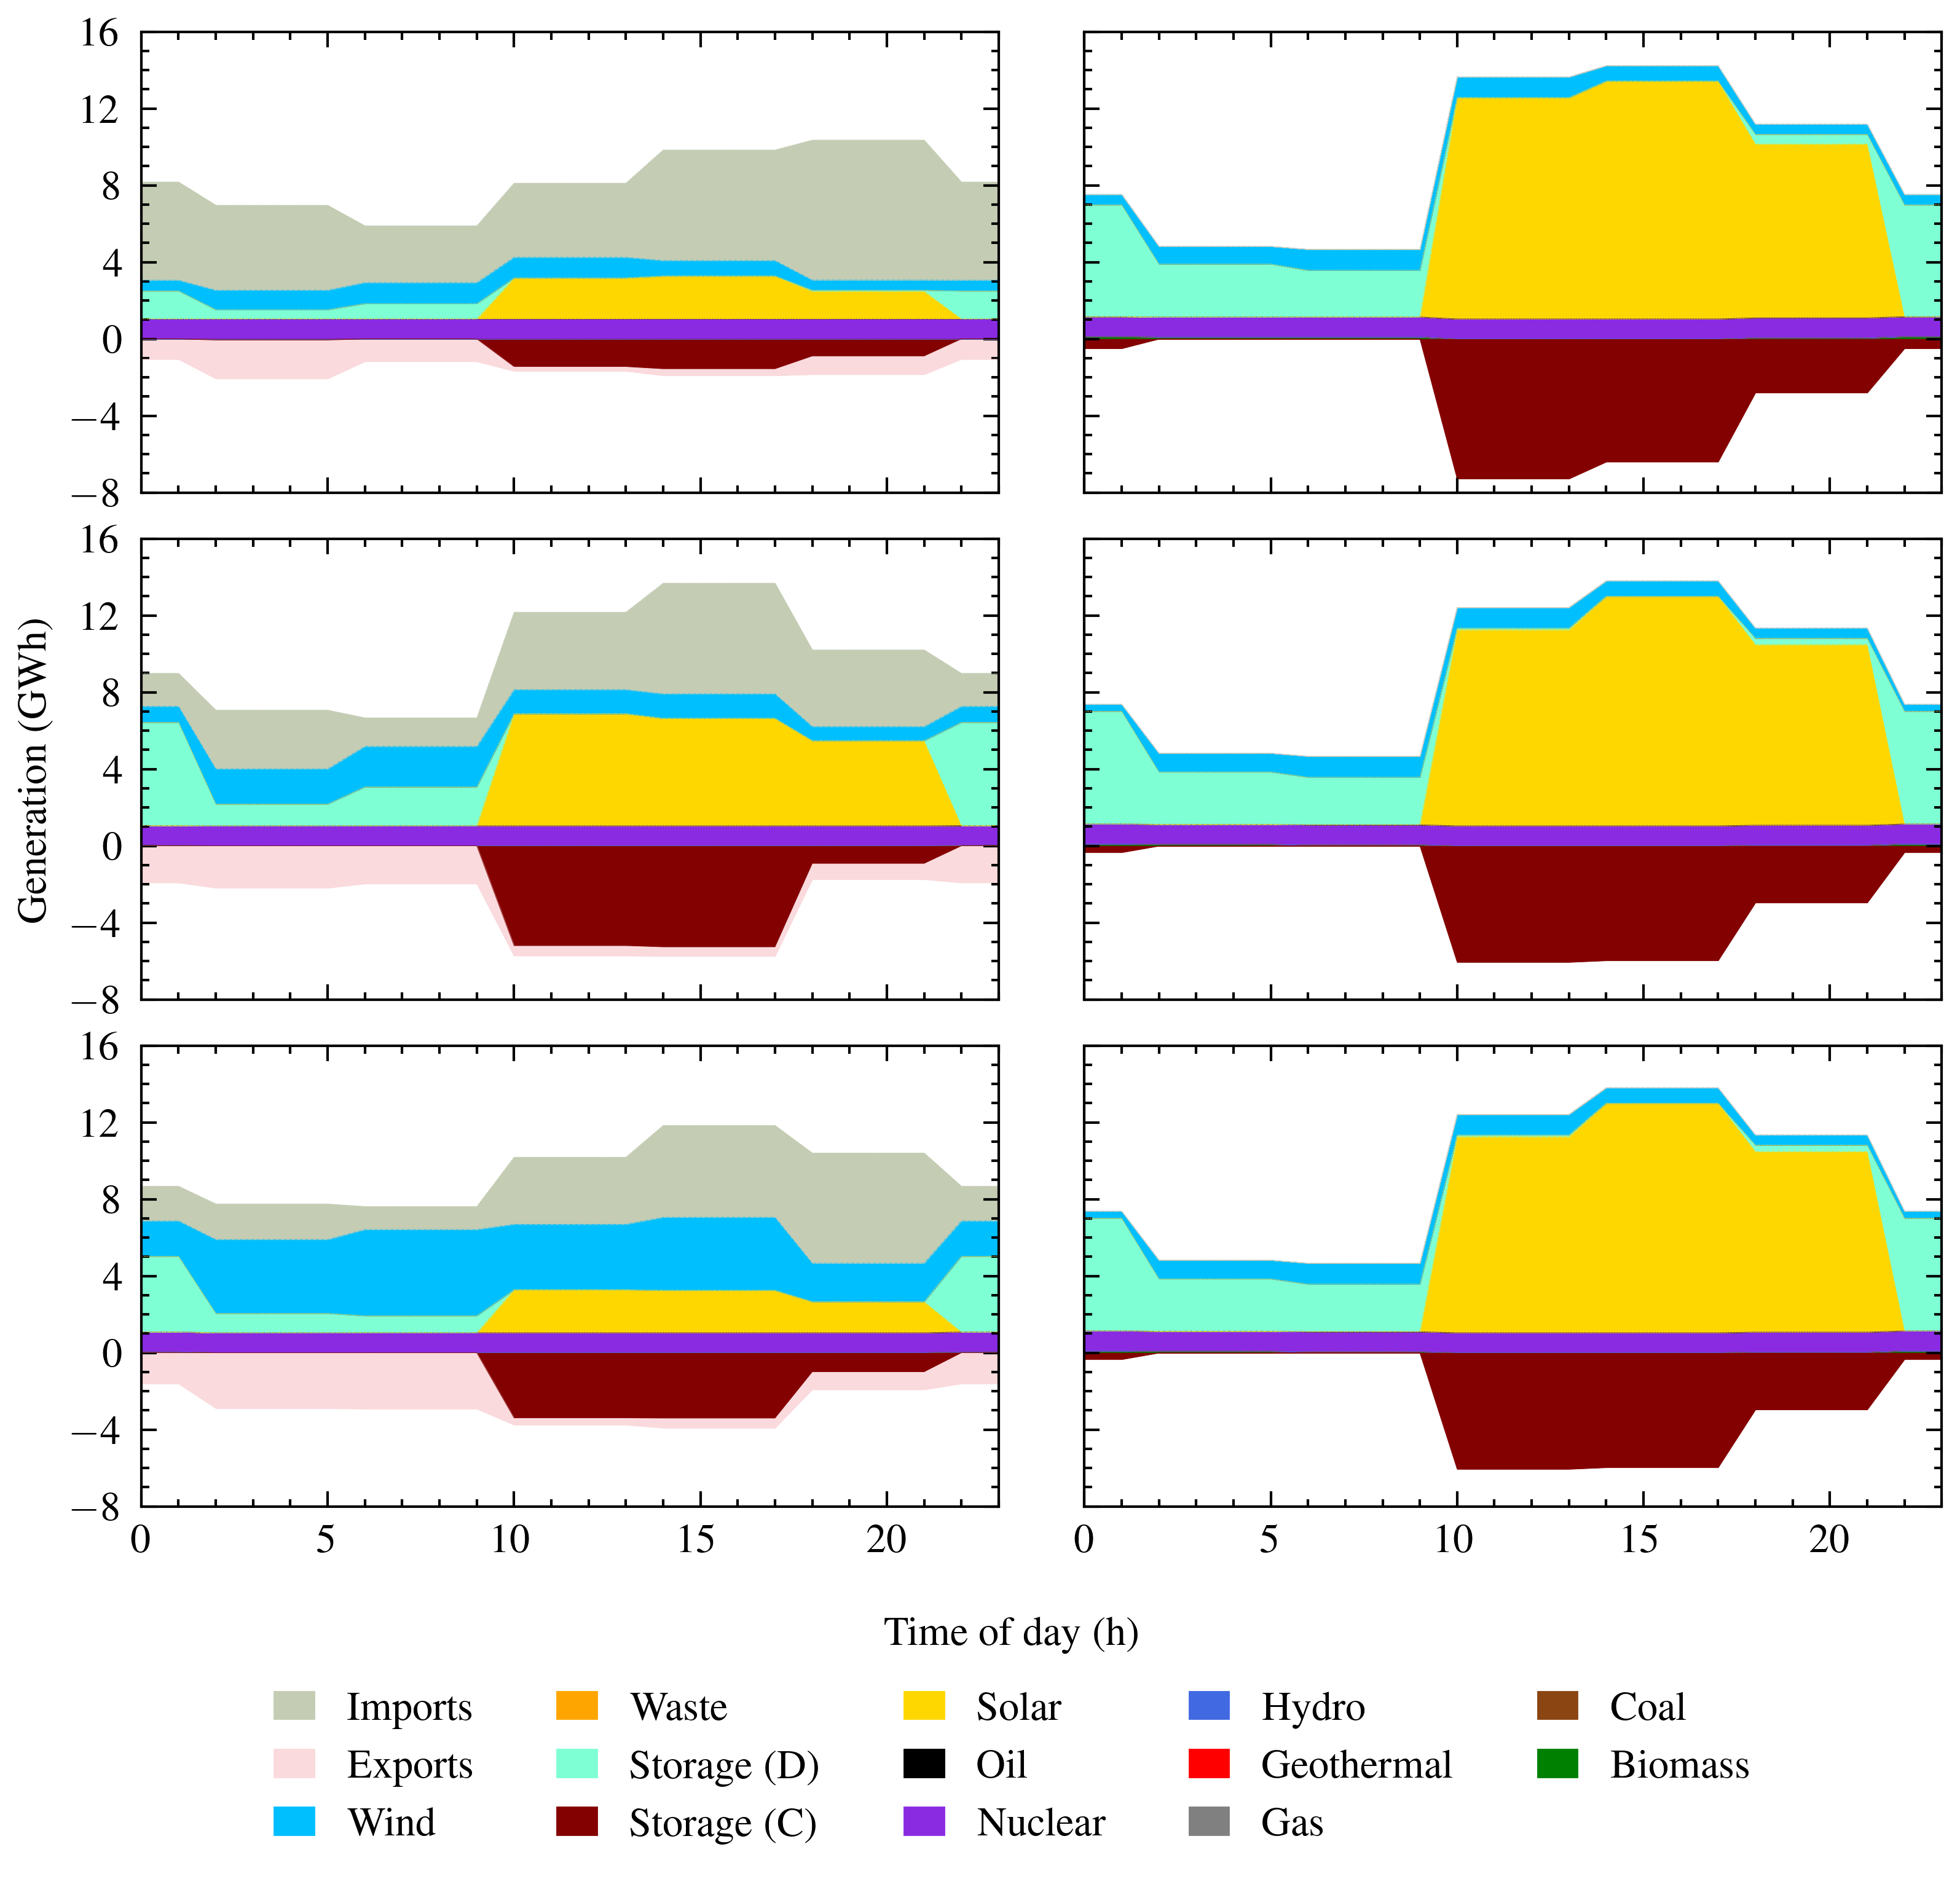

In [120]:
y_lower=-8
y_upper=16
y_ticks=np.arange(-8, 17, 4)
y_label_name = 'Generation (GWh)'
x_label_name = 'Time of day (h)'

fig, ((ax11, ax12), (ax21, ax22), (ax31, ax32)) = plt.subplots(nrows=3, ncols=2, figsize=(6.3,5))
plt.subplots_adjust(left  = 0.125,  # the left side of the subplots of the figure
                    right = 0.9 ,   # the right side of the subplots of the figure
                    bottom = 0.1,   # the bottom of the subplots of the figure
                    top = 0.9,      # the top of the subplots of the figure
                    wspace = 0.1,   # the amount of width reserved for blank space between subplots
                    hspace = 0.1)   # the amount of height reserved for white space between subplots

ax11 = nm_daily_ultralow[tech_order].plot.area(stacked=True,ax=ax11, color=tech_colors, rot=0, lw=0.1,legend=None)
ax11.set_ylim(y_lower,y_upper)
ax11.set_yticks(y_ticks)
ax11.set_xlim(nm_daily_ultralow.index[0], nm_daily_ultralow.index[-1])
plt.setp(ax11.get_xticklabels(), visible=False)
ax11.set_xlabel('')

ax12 = nm_is_daily_ultralow[tech_order].plot.area(stacked=True,ax=ax12, color=tech_colors, rot=0, lw=0.1,legend=None)
ax12.set_ylim(y_lower,y_upper)
ax12.set_yticks(y_ticks)
ax12.set_xlim(nm_is_daily_ultralow.index[0], nm_is_daily_ultralow.index[-1])
plt.setp(ax12.get_yticklabels(), visible=False)
plt.setp(ax12.get_xticklabels(), visible=False)
ax12.set_xlabel('')

ax21 = nm_daily_medium[tech_order].plot.area(stacked=True,ax=ax21, color=tech_colors, rot=0, lw=0.1, legend=None)
ax21.set_ylim(y_lower,y_upper)
ax21.set_yticks(y_ticks)
ax21.set_xlim(nm_daily_medium.index[0], nm_daily_medium.index[-1])
plt.setp(ax21.get_xticklabels(), visible=False)
ax21.set_xlabel('')

ax22 = nm_is_daily_medium[tech_order].plot.area(stacked=True,ax=ax22, color=tech_colors, rot=0, lw=0.1, legend=None)
ax22.set_ylim(y_lower,y_upper)
ax22.set_yticks(y_ticks)
ax22.set_xlim(nm_is_daily_medium.index[0], nm_is_daily_medium.index[-1])
plt.setp(ax22.get_yticklabels(), visible=False)
plt.setp(ax22.get_xticklabels(), visible=False)
ax22.set_xlabel('')

ax31 = nm_daily_base[tech_order].plot.area(stacked=True,ax=ax31, color=tech_colors, rot=0, lw=0.1, legend=None)
ax31.set_ylim(y_lower,y_upper)
ax31.set_yticks(y_ticks)
ax31.set_xlim(nm_daily_base.index[0], nm_daily_base.index[-1])
ax31.set_xlabel('')

ax32 = nm_is_daily_base[tech_order].plot.area(stacked=True,ax=ax32, color=tech_colors, rot=0, lw=0.1, legend=None)
ax32.set_ylim(y_lower,y_upper)
ax32.set_yticks(y_ticks)
ax32.set_ylim(y_lower,y_upper)
ax32.set_xlim(nm_is_daily_base.index[0], nm_is_daily_base.index[-1])
plt.setp(ax32.get_yticklabels(), visible=False)
ax32.set_xlabel('')
handles, labels = ax32.get_legend_handles_labels()

fig.text(0.08, 0.5, y_label_name, ha='center', va='center', rotation='vertical')
fig.text(0.5, 0.03, x_label_name, ha='center', va='center', rotation='horizontal')

fig.legend(
    handles[::-1],
    labels[::-1],
    bbox_to_anchor=(0.5,0.02),
    loc="upper center",
    ncol=5,
    handlelength=1,
    edgecolor="black",
    facecolor="white",
)

In [ ]:
test = dpch_test.copy()
test = test[(time_1 <= test.timestamp) & (test.timestamp < time_2)]
test = test.pivot_table(index="hour", columns='tech_map', values="DispatchGen_MWh", aggfunc=np.sum)
for k in tech_order:
        if not k in test.columns:
            test[k]=0
test = test / ((time_2 - time_1).days)
test2=test.copy()
test2=test2[tech_order]

idx = list(daily_dispatch_source.index)
odd = [i for i in idx if i % 2 == 1]
even = [i for i in idx if i % 2 == 0]
for k in even:
    full_daily_dispatch.loc[k+1,:]=full_daily_dispatch.loc[k,:]
for h in odd:
    if h == 1:
        full_daily_dispatch.loc[24,:]=full_daily_dispatch.loc[h,:]
    else:
        full_daily_dispatch.loc[h-1,:]=full_daily_dispatch.loc[h,:]
full_daily_dispatch.sort_index(inplace=True)

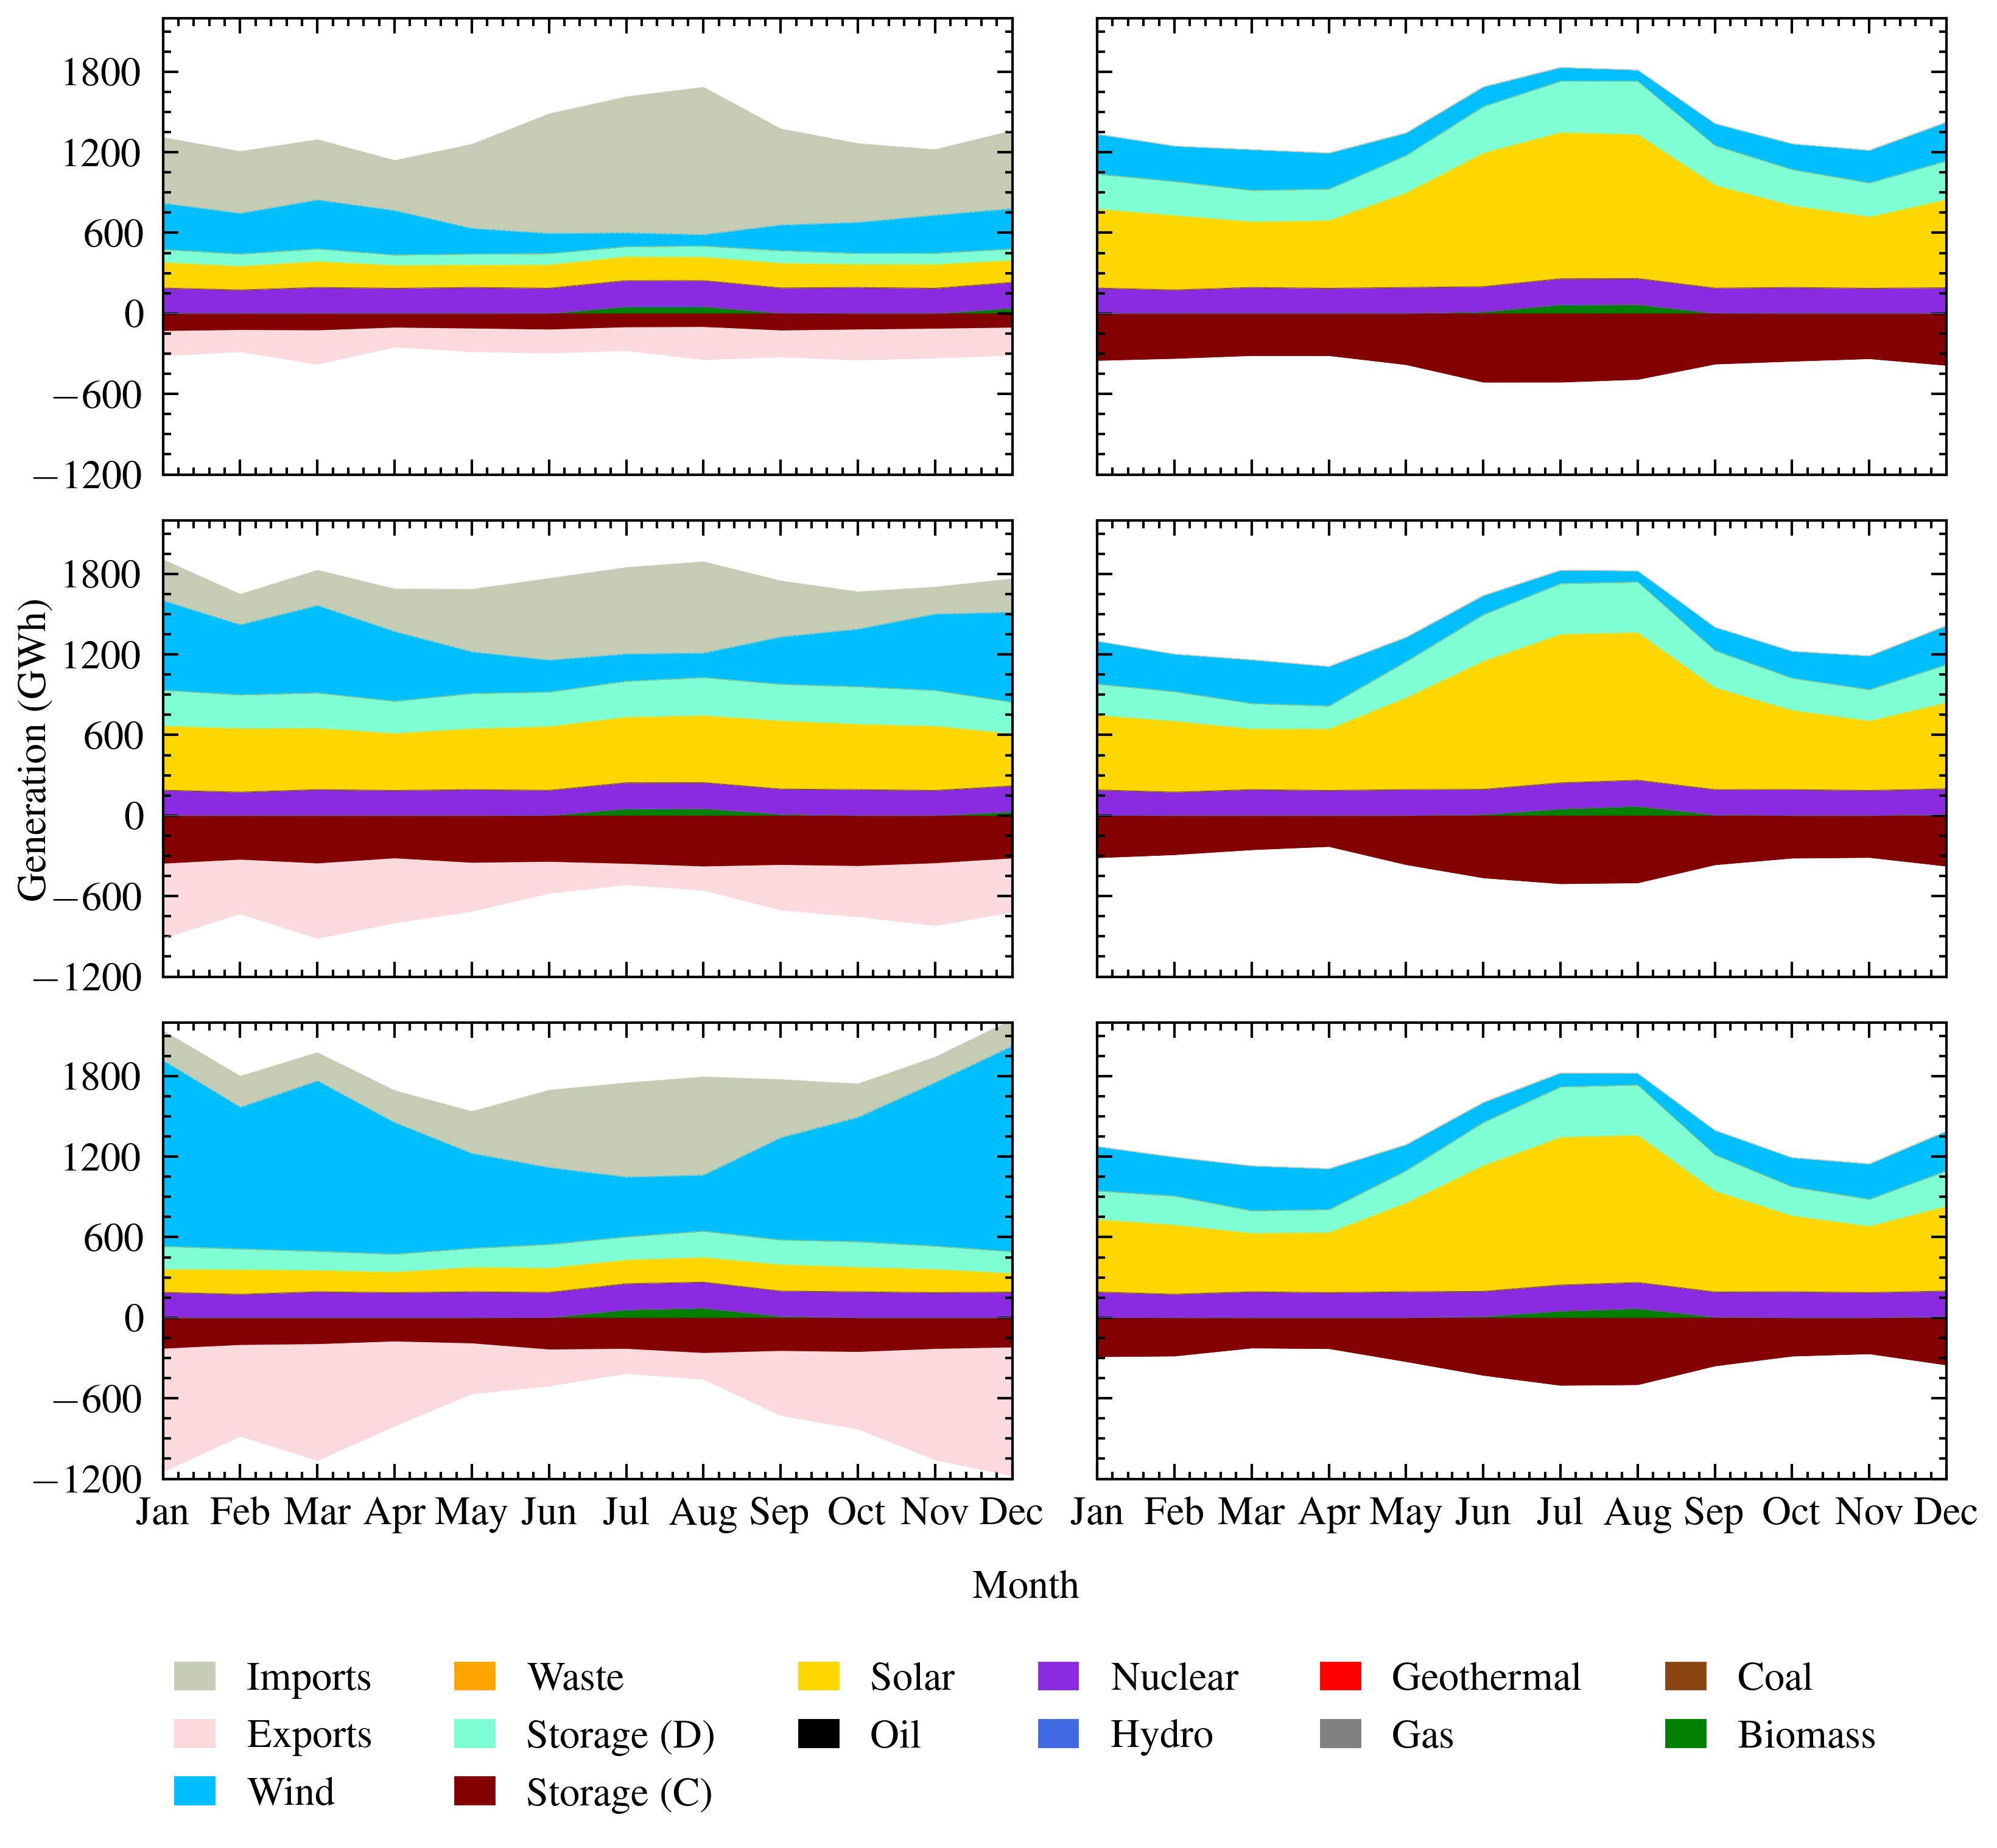

In [97]:
y_lower=-1200
y_upper=2200
y_ticks=np.arange(-1200, 2201, 600)
y_label_name = 'Generation (GWh)'
x_label_name = 'Month'

#IEEE sizes: 3.3, 2.5
fig, ((ax11, ax12), (ax21, ax22), (ax31, ax32)) = plt.subplots(nrows=3, ncols=2, figsize=(6.3,5))
plt.subplots_adjust(left  = 0.125,  # the left side of the subplots of the figure
                    right = 0.9 ,   # the right side of the subplots of the figure
                    bottom = 0.1,   # the bottom of the subplots of the figure
                    top = 0.9,      # the top of the subplots of the figure
                    wspace = 0.1,   # the amount of width reserved for blank space between subplots
                    hspace = 0.1)   # the amount of height reserved for white space between subplots

ax11 = nm_monthly_ultralow[tech_order].plot.area(stacked=True,ax=ax11, color=tech_colors, rot=0, lw=0.1,legend=None)
ax11.set_ylim(y_lower,y_upper)
ax11.set_yticks(y_ticks)
ax11.set_xlim(nm_monthly_ultralow.index[0], nm_monthly_ultralow.index[-2])
ax11.set_xticks(np.linspace(1,12,12), m12_ticks,  rotation=0)
plt.setp(ax11.get_xticklabels(), visible=False)
ax11.set_xlabel('')

ax12 = nm_is_monthly_ultralow[tech_order].plot.area(stacked=True,ax=ax12, color=tech_colors, rot=0, lw=0.1,legend=None)
ax12.set_ylim(y_lower,y_upper)
ax12.set_yticks(y_ticks)
ax12.set_xlim(nm_is_monthly_ultralow.index[0], nm_is_monthly_ultralow.index[-2])
ax12.set_xticks(np.linspace(1,12,12), m12_ticks,  rotation=0)
plt.setp(ax12.get_yticklabels(), visible=False)
plt.setp(ax12.get_xticklabels(), visible=False)
ax12.set_xlabel('')

ax21 = nm_monthly_medium[tech_order].plot.area(stacked=True,ax=ax21, color=tech_colors, rot=0, lw=0.1, legend=None)
ax21.set_ylim(y_lower,y_upper)
ax21.set_yticks(y_ticks)
ax21.set_xlim(nm_monthly_medium.index[0], nm_monthly_medium.index[-2])
ax21.set_xticks(np.linspace(1,12,12), m12_ticks,  rotation=0)
plt.setp(ax21.get_xticklabels(), visible=False)
ax21.set_xlabel('')

ax22 = nm_is_monthly_medium[tech_order].plot.area(stacked=True,ax=ax22, color=tech_colors, rot=0, lw=0.1, legend=None)
ax22.set_ylim(y_lower,y_upper)
ax22.set_yticks(y_ticks)
ax22.set_xlim(nm_is_monthly_medium.index[0], nm_is_monthly_medium.index[-2])
ax22.set_xticks(np.linspace(1,12,12), m12_ticks,  rotation=0)
ax22.set_xlabel('')
plt.setp(ax22.get_xticklabels(), visible=False)
plt.setp(ax22.get_yticklabels(), visible=False)

ax31 = nm_monthly_base[tech_order].plot.area(stacked=True,ax=ax31, color=tech_colors, rot=0, lw=0.1, legend=None)
ax31.set_ylim(y_lower,y_upper)
ax31.set_yticks(y_ticks)
ax31.set_xticks(np.linspace(1,12,12), m12_ticks,  rotation=0)
ax31.set_xlim(nm_is_monthly_base.index[0], nm_monthly_base.index[-1])
ax31.set_xlabel('')


ax32 = nm_is_monthly_base[tech_order].plot.area(stacked=True,ax=ax32, color=tech_colors, rot=0, lw=0.1, legend=None)
ax32.set_ylim(y_lower,y_upper)
ax32.set_yticks(y_ticks)
ax32.set_ylim(y_lower,y_upper)
ax32.set_xticks(np.linspace(1,12,12), m12_ticks,  rotation=0)
ax32.set_xlim(nm_is_monthly_base.index[0], nm_is_monthly_base.index[-1])
plt.setp(ax32.get_yticklabels(), visible=False)
ax32.set_xlabel('')

handles, labels = ax32.get_legend_handles_labels()

fig.text(0.07, 0.5, y_label_name, ha='center', va='center', rotation='vertical')
fig.text(0.5, 0.04, x_label_name, ha='center', va='center', rotation='horizontal')

fig.legend(
    handles[::-1],
    labels[::-1],
    bbox_to_anchor=(0.5,0.02),
    loc="upper center",
    ncol=6,
    handlelength=1,
    edgecolor="black",
    facecolor="white",
)

In [ ]:
timepoints = get_data(scenario, "timepoints.csv", fpath='inputs')
timepoints.columns= timepoints .columns.str.lower()
timepoints.rename(columns={'timepoint_id': 'timepoint'}, inplace=True)
timepoints  = timepoints .replace({"scenario": short_names})


In [ ]:
loads = get_data(scenario, "loads.csv", fpath='inputs')
loads  = loads .replace({"scenario": short_names})
loads.columns= loads.columns.str.lower()
loads=loads.loc[loads.load_zone.isin(zone) & loads.scenario.isin(sc)]

loads=pd.merge(loads, timepoints[['timepoint', 'timestamp', 'scenario']], how='left', on=['timepoint', 'scenario'])
loads=pd.merge(loads, z_time, how='left', on=['timestamp', 'scenario'])
loads.drop(['timepoint'], axis=1, inplace=True)
loads['load_MWh']=loads['zone_demand_mw']*loads['tp_weight_in_year_hrs']

### Daily dispatch

,load_zone,zone_demand_mw,scenario,timestamp,tp_weight_in_year_hrs,load_MWh,hour,Load
182,NM_N,"1,737.45",0.46,2035-02-01 01:00:00-07:00,4.01,"6,973.62",1,6.97
183,NM_N,"1,902.51",0.46,2035-02-01 05:00:00-07:00,4.01,"7,636.11",5,7.64
184,NM_N,"2,482.07",0.46,2035-02-01 09:00:00-07:00,4.01,"9,962.30",9,9.96
185,NM_N,"2,354.04",0.46,2035-02-01 13:00:00-07:00,4.01,"9,448.43",13,9.45
186,NM_N,"2,585.85",0.46,2035-02-01 17:00:00-07:00,4.01,"10,378.83",17,10.38
...,...,...,...,...,...,...,...,...
344,NM_N,"1,635.04",0.46,2035-02-28 01:00:00-07:00,4.01,"6,562.57",1,6.56
345,NM_N,"1,775.59",0.46,2035-02-28 05:00:00-07:00,4.01,"7,126.70",5,7.13
346,NM_N,"2,143.25",0.46,2035-02-28 09:00:00-07:00,4.01,"8,602.35",9,8.60
347,NM_N,"1,797.45",0.46,2035-02-28 13:00:00-07:00,4.01,"7,214.43",13,7.21


In [253]:

#Get the dataframe using the time_1 and time_2
d_1=loads.copy()
d_1=d_1[(time_1 <= d_1.timestamp) & (d_1.timestamp <= time_2)]

#Create a column that has the hour of the timestamp
d_1['hour']=d_1['timestamp'].dt.hour

#Create a column that has the energy in GWh
d_1['Load']=d_1['load_MWh']*10**(-3)


#Get the daily dispatch
daily_demand= d_1.pivot_table(
    index="hour",
    values="Load",
    aggfunc=np.sum,
)
daily_demand

,Load
hour,
1,187.19
5,195.45
9,240.95
13,216.32
17,227.45
21,228.66


In [255]:
#New dataframe
full_daily_demand=daily_demand.copy()

#Number of timestamps
ntimestamp=len(d_1.timestamp.unique())

#Average timestamp dispatch
full_daily_demand=full_daily_demand/ntimestamp

#Replicate the rows to fill up the hours of the time interval. For example, if the time interval comprises 4 hours, then copy the result of 
#hour and replicate them.
#Number of hours of a time block
time_range=4 
for h in list(daily_demand.index):
    for k in range(0,time_range):
       full_daily_demand.loc[h+k,:]=full_daily_demand.loc[h,:]

#If the hour index is greater than 24, the row is reindex with h-24, and then it is dropped.
for h in list(full_daily_demand.index):
    if h>=24:
      full_daily_demand.loc[h-24,:]=full_daily_demand.loc[h,:]
      full_daily_demand.drop(index=h, inplace=True)

#Sort the dataframe to have it chronologic
full_daily_demand.sort_index(inplace=True)

full_daily_demand

,Load
hour,
0,1.37
1,1.12
2,1.12
3,1.12
4,1.12
5,1.17
6,1.17
7,1.17
8,1.17


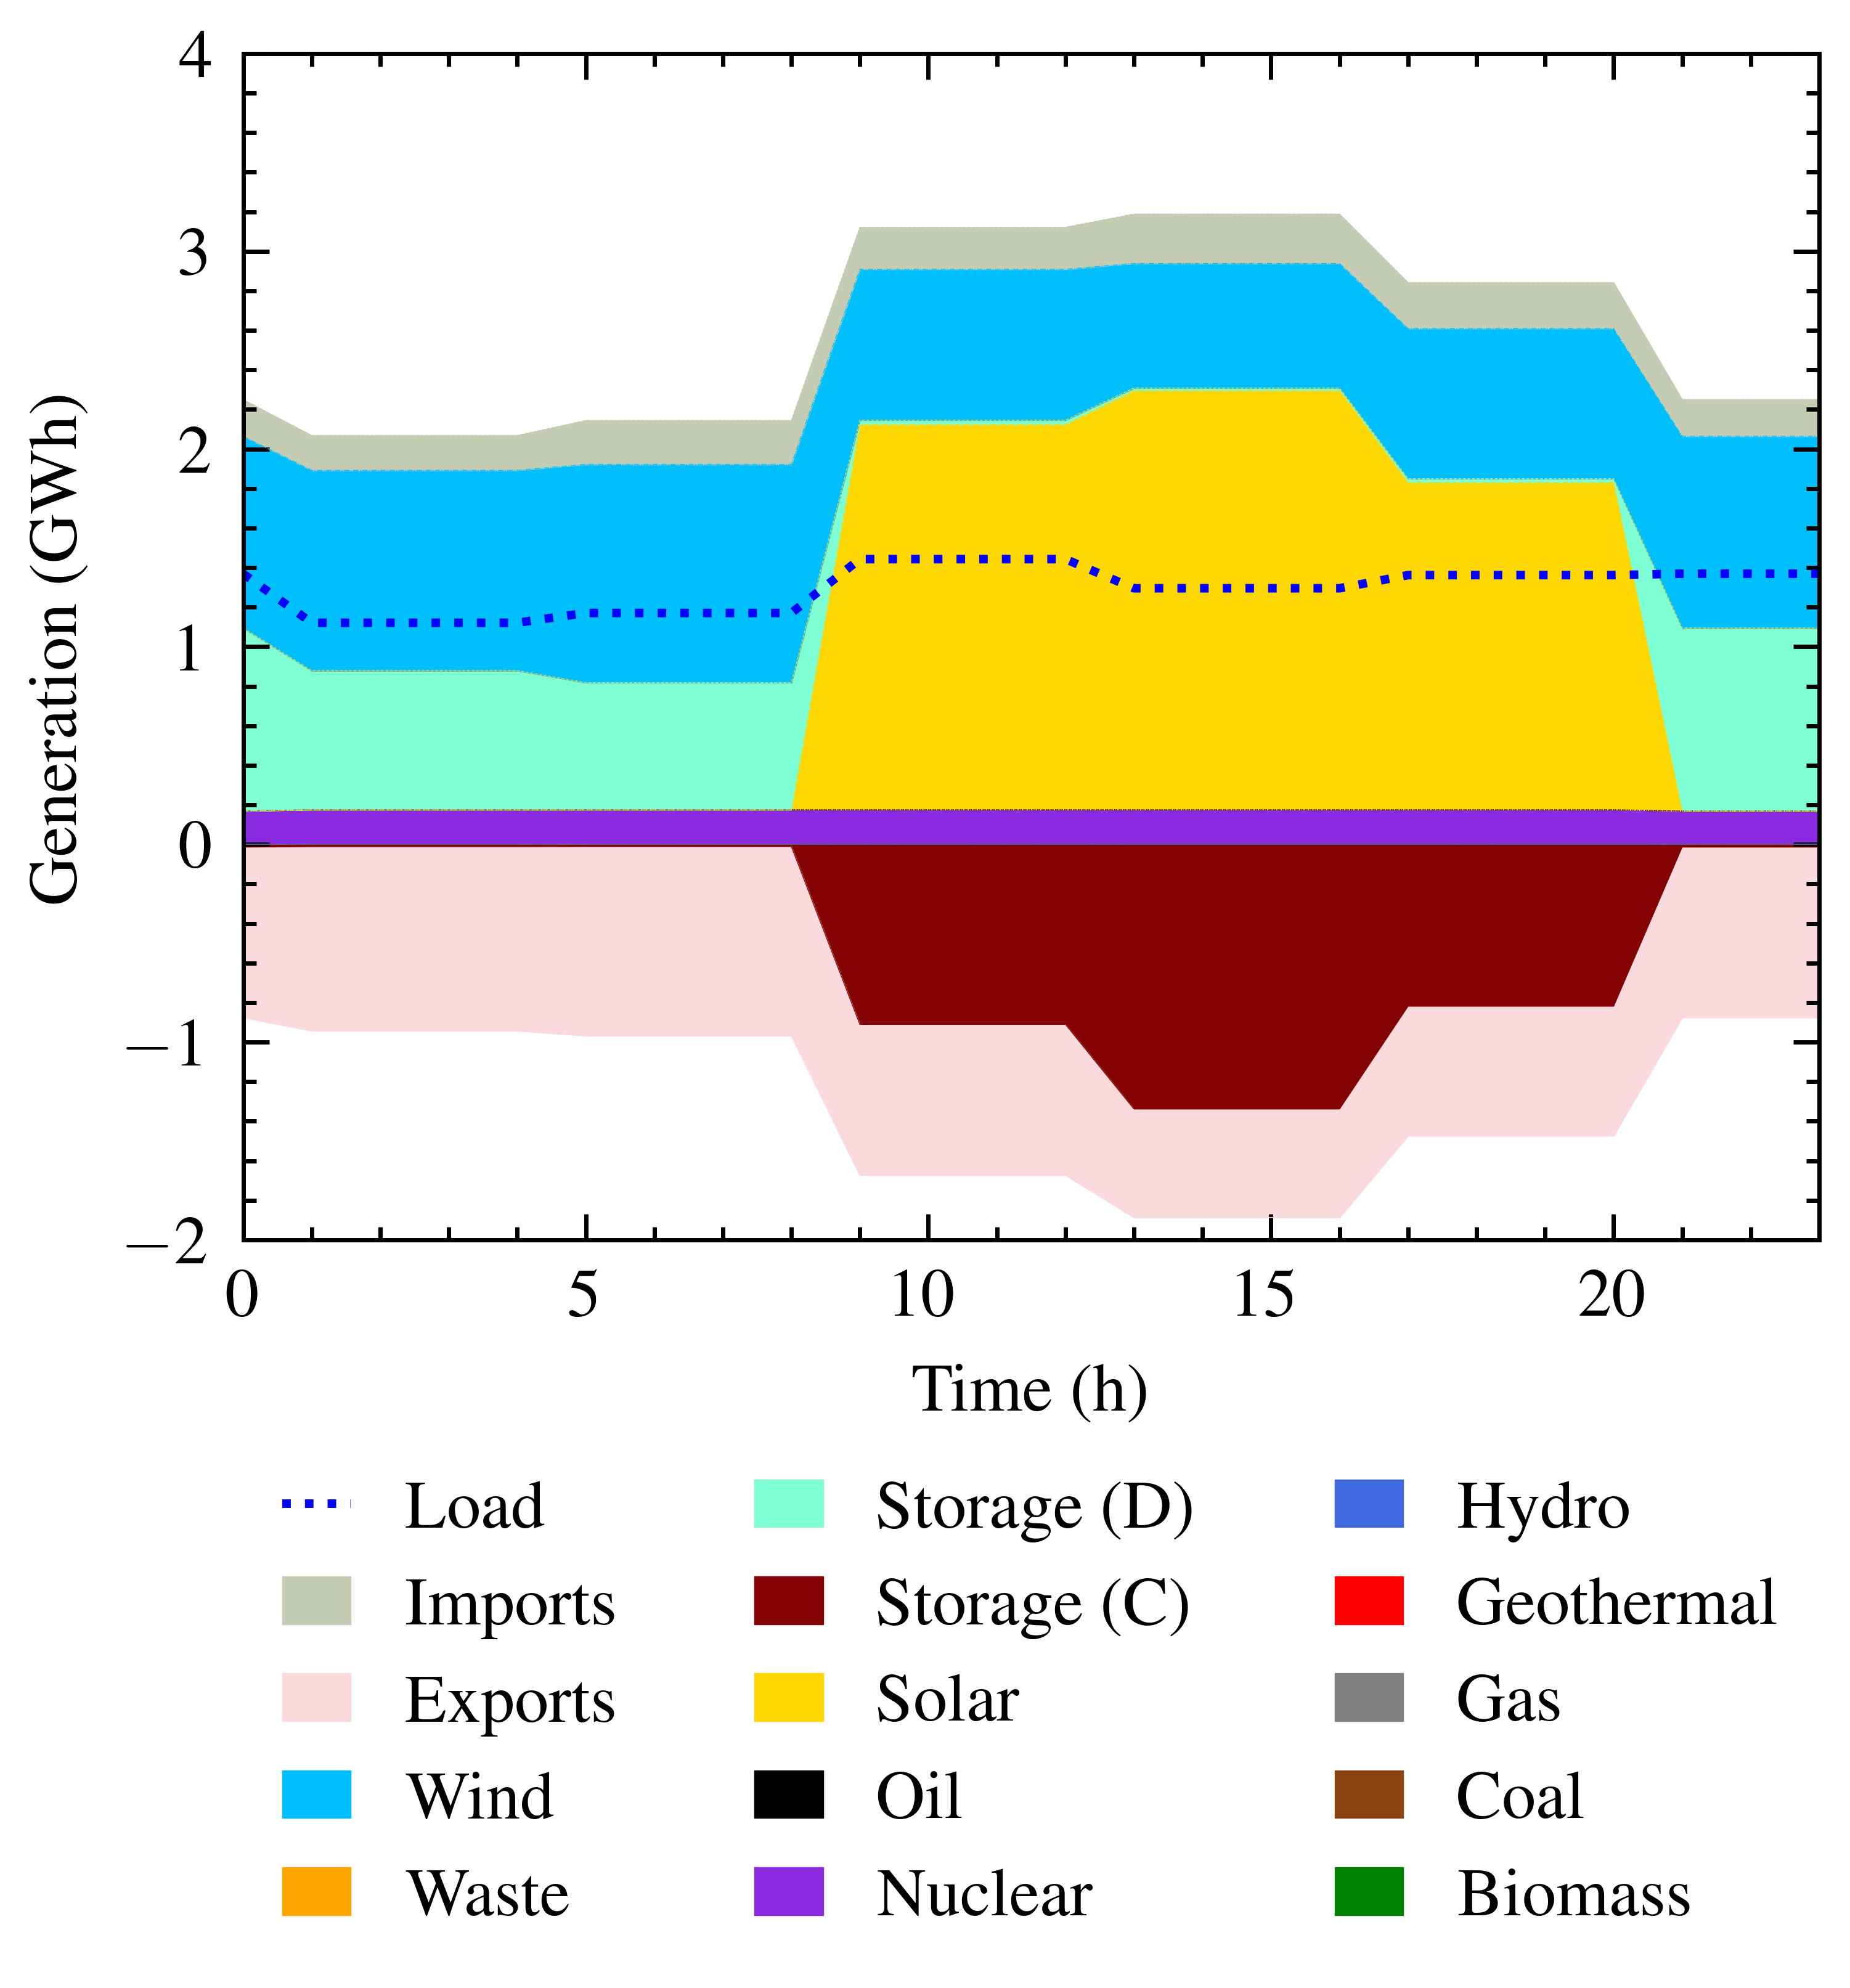

In [256]:
#arning: Fix ax.set_ylim

# Initialize figure environment
fig, ax = plt.subplots(dpi=1000)

# Main plot
ax = full_daily_dispatch[tech_order].plot.area(stacked=True,ax=ax, color=tech_colors, rot=0, lw=0.1)

ax = full_daily_demand.plot.line(ax=ax, rot=0, lw=1)


# Label configuration
plt.xlabel("Time (h)")
plt.ylabel("Generation (GWh)")

# Legend configuration
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1],
    labels[::-1],
    bbox_to_anchor=(0.5, -0.15),
    loc="upper center",
    ncol=3,
    handlelength=1,
    fancybox=True,
    edgecolor="black",
    facecolor="white",
)
ax.set_ylim(-2,4)
ax.set_xlim(full_daily_dispatch.index[0], full_daily_dispatch.index[-1])

plt.savefig(folder_to_save_results + str(sc) + " scenario daily dispatch from " + str(time_1) + " to " + str(time_2) + " in "+ str(zone)  +".pdf" , transparent=False)

In [225]:
#z_dpch.to_csv(folder_to_save_results+'central_dispatch_PNM.csv',index=False, columns=['generation_project', 'timestamp', 'gen_tech', 'gen_load_zone', 'DispatchGen_MWh'])

### Monthly dispatch

In [226]:
time_1=2035010100
time_2=2036010100

time_1=datetime.strptime(str(time_1), '%Y%m%d%H').astimezone(timezone('US/Mountain'))
time_2=datetime.strptime(str(time_2), '%Y%m%d%H').astimezone(timezone('US/Mountain'))

#Get the dataframe using the time_1 and time_2
a_1=z_dpch.copy()
a_1=a_1[(time_1 <= a_1.timestamp) & (a_1.timestamp <= time_2)]

#Create a column that has the hour of the timestamp
a_1['month']=a_1['timestamp'].dt.month

#Create a column that has the energy in GWh
a_1['DispatchGen_GWh']=a_1['DispatchGen_MWh']*10**(-3)

a_1

,generation_project,timestamp,gen_tech,gen_load_zone,tp_weight_in_year_hrs,DispatchGen_MW,tech_map,scenario,DispatchGen_MWh,month,DispatchGen_GWh
1718808,155255,2035-01-01 17:00:00-07:00,Gas_Steam_Turbine,NM_N,4.01,0.00,Gas,0.46,0.00,1,0.00
1718809,155255,2035-01-01 21:00:00-07:00,Gas_Steam_Turbine,NM_N,4.01,0.00,Gas,0.46,0.00,1,0.00
1718810,155255,2035-01-02 01:00:00-07:00,Gas_Steam_Turbine,NM_N,4.01,0.00,Gas,0.46,0.00,1,0.00
1718811,155255,2035-01-02 05:00:00-07:00,Gas_Steam_Turbine,NM_N,4.01,0.00,Gas,0.46,0.00,1,0.00
1718812,155255,2035-01-02 09:00:00-07:00,Gas_Steam_Turbine,NM_N,4.01,0.00,Gas,0.46,0.00,1,0.00
...,...,...,...,...,...,...,...,...,...,...,...
17467,NM_S_TX_EPENM_N,2035-12-30 21:00:00-07:00,Imports,NM_N,4.01,4.17,Imports,0.46,16.75,12,0.02
17468,NM_S_TX_EPENM_N,2035-12-31 01:00:00-07:00,Imports,NM_N,4.01,4.68,Imports,0.46,18.79,12,0.02
17469,NM_S_TX_EPENM_N,2035-12-31 05:00:00-07:00,Imports,NM_N,4.01,6.64,Imports,0.46,26.65,12,0.03
17470,NM_S_TX_EPENM_N,2035-12-31 09:00:00-07:00,Imports,NM_N,4.01,40.45,Imports,0.46,162.37,12,0.16


In [227]:
#Get the monthly dispatch
monthly_dispatch_source= a_1.pivot_table(
    index="month",
    columns="tech_map",
    values="DispatchGen_GWh",
    aggfunc=np.sum,
)
#Add the technologies that are in tech order but have dispatch zero. This serves to order the stacked area plot according to the tech order vector
for k in tech_order:
    if not k in monthly_dispatch_source.columns:
        monthly_dispatch_source[k]=0
monthly_dispatch_source

tech_map,Biomass,Exports,Gas,Imports,Nuclear,Solar,Storage (C),Storage (D),Wind,Coal,Geothermal,Hydro,Oil,Waste
month,,,,,,,,,,,,,,
1,1.08,-993.38,0.00,295.96,189.04,961.62,-524.87,394.21,"1,104.09",0,0,0,0,0
2,0.98,-796.72,0.00,215.75,174.50,955.83,-518.44,394.15,883.33,0,0,0,0,0
3,1.09,"-1,031.16",0.00,241.36,193.20,966.37,-506.92,377.35,"1,025.35",0,0,0,0,0
4,1.03,-791.54,0.00,213.11,186.97,928.94,-445.04,334.03,779.96,0,0,0,0,0
5,1.06,-605.57,0.00,319.56,193.20,984.44,-515.66,387.04,528.99,0,0,0,0,0
6,9.88,-565.36,0.00,436.12,186.97,"1,109.83",-566.03,425.25,449.12,0,0,0,0,0
7,46.67,-537.81,0.00,407.11,193.20,"1,312.65",-587.04,440.08,361.72,0,0,0,0,0
8,47.18,-510.88,0.00,493.87,193.20,"1,252.15",-604.77,452.65,312.56,0,0,0,0,0
9,16.75,-790.26,0.00,362.90,186.97,"1,092.86",-583.43,438.19,605.20,0,0,0,0,0


In [228]:
'''
#Get the technologies that have zero energy for all the hours.
non_zero=list()
for t in list(monthly_dispatch_source.columns):
    if monthly_dispatch_source[t].sum():
        non_zero.append(t)

#Drop the technologies with zero dispatch
monthly_dispatch_source=monthly_dispatch_source.loc[:,non_zero]
'''

'\n#Get the technologies that have zero energy for all the hours.\nnon_zero=list()\nfor t in list(monthly_dispatch_source.columns):\n    if monthly_dispatch_source[t].sum():\n        non_zero.append(t)\n\n#Drop the technologies with zero dispatch\nmonthly_dispatch_source=monthly_dispatch_source.loc[:,non_zero]\n'

In [229]:
monthly_dispatch_source

tech_map,Biomass,Exports,Gas,Imports,Nuclear,Solar,Storage (C),Storage (D),Wind,Coal,Geothermal,Hydro,Oil,Waste
month,,,,,,,,,,,,,,
1,1.08,-993.38,0.00,295.96,189.04,961.62,-524.87,394.21,"1,104.09",0,0,0,0,0
2,0.98,-796.72,0.00,215.75,174.50,955.83,-518.44,394.15,883.33,0,0,0,0,0
3,1.09,"-1,031.16",0.00,241.36,193.20,966.37,-506.92,377.35,"1,025.35",0,0,0,0,0
4,1.03,-791.54,0.00,213.11,186.97,928.94,-445.04,334.03,779.96,0,0,0,0,0
5,1.06,-605.57,0.00,319.56,193.20,984.44,-515.66,387.04,528.99,0,0,0,0,0
6,9.88,-565.36,0.00,436.12,186.97,"1,109.83",-566.03,425.25,449.12,0,0,0,0,0
7,46.67,-537.81,0.00,407.11,193.20,"1,312.65",-587.04,440.08,361.72,0,0,0,0,0
8,47.18,-510.88,0.00,493.87,193.20,"1,252.15",-604.77,452.65,312.56,0,0,0,0,0
9,16.75,-790.26,0.00,362.90,186.97,"1,092.86",-583.43,438.19,605.20,0,0,0,0,0


In [230]:
month_dic={1:'Jan', 2: 'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7: 'Jul', 8:'Aug', 9:'Sep', 10: 'Oct', 11: 'Nov', 12:'Dec'}

In [231]:
m12_ticks=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']  

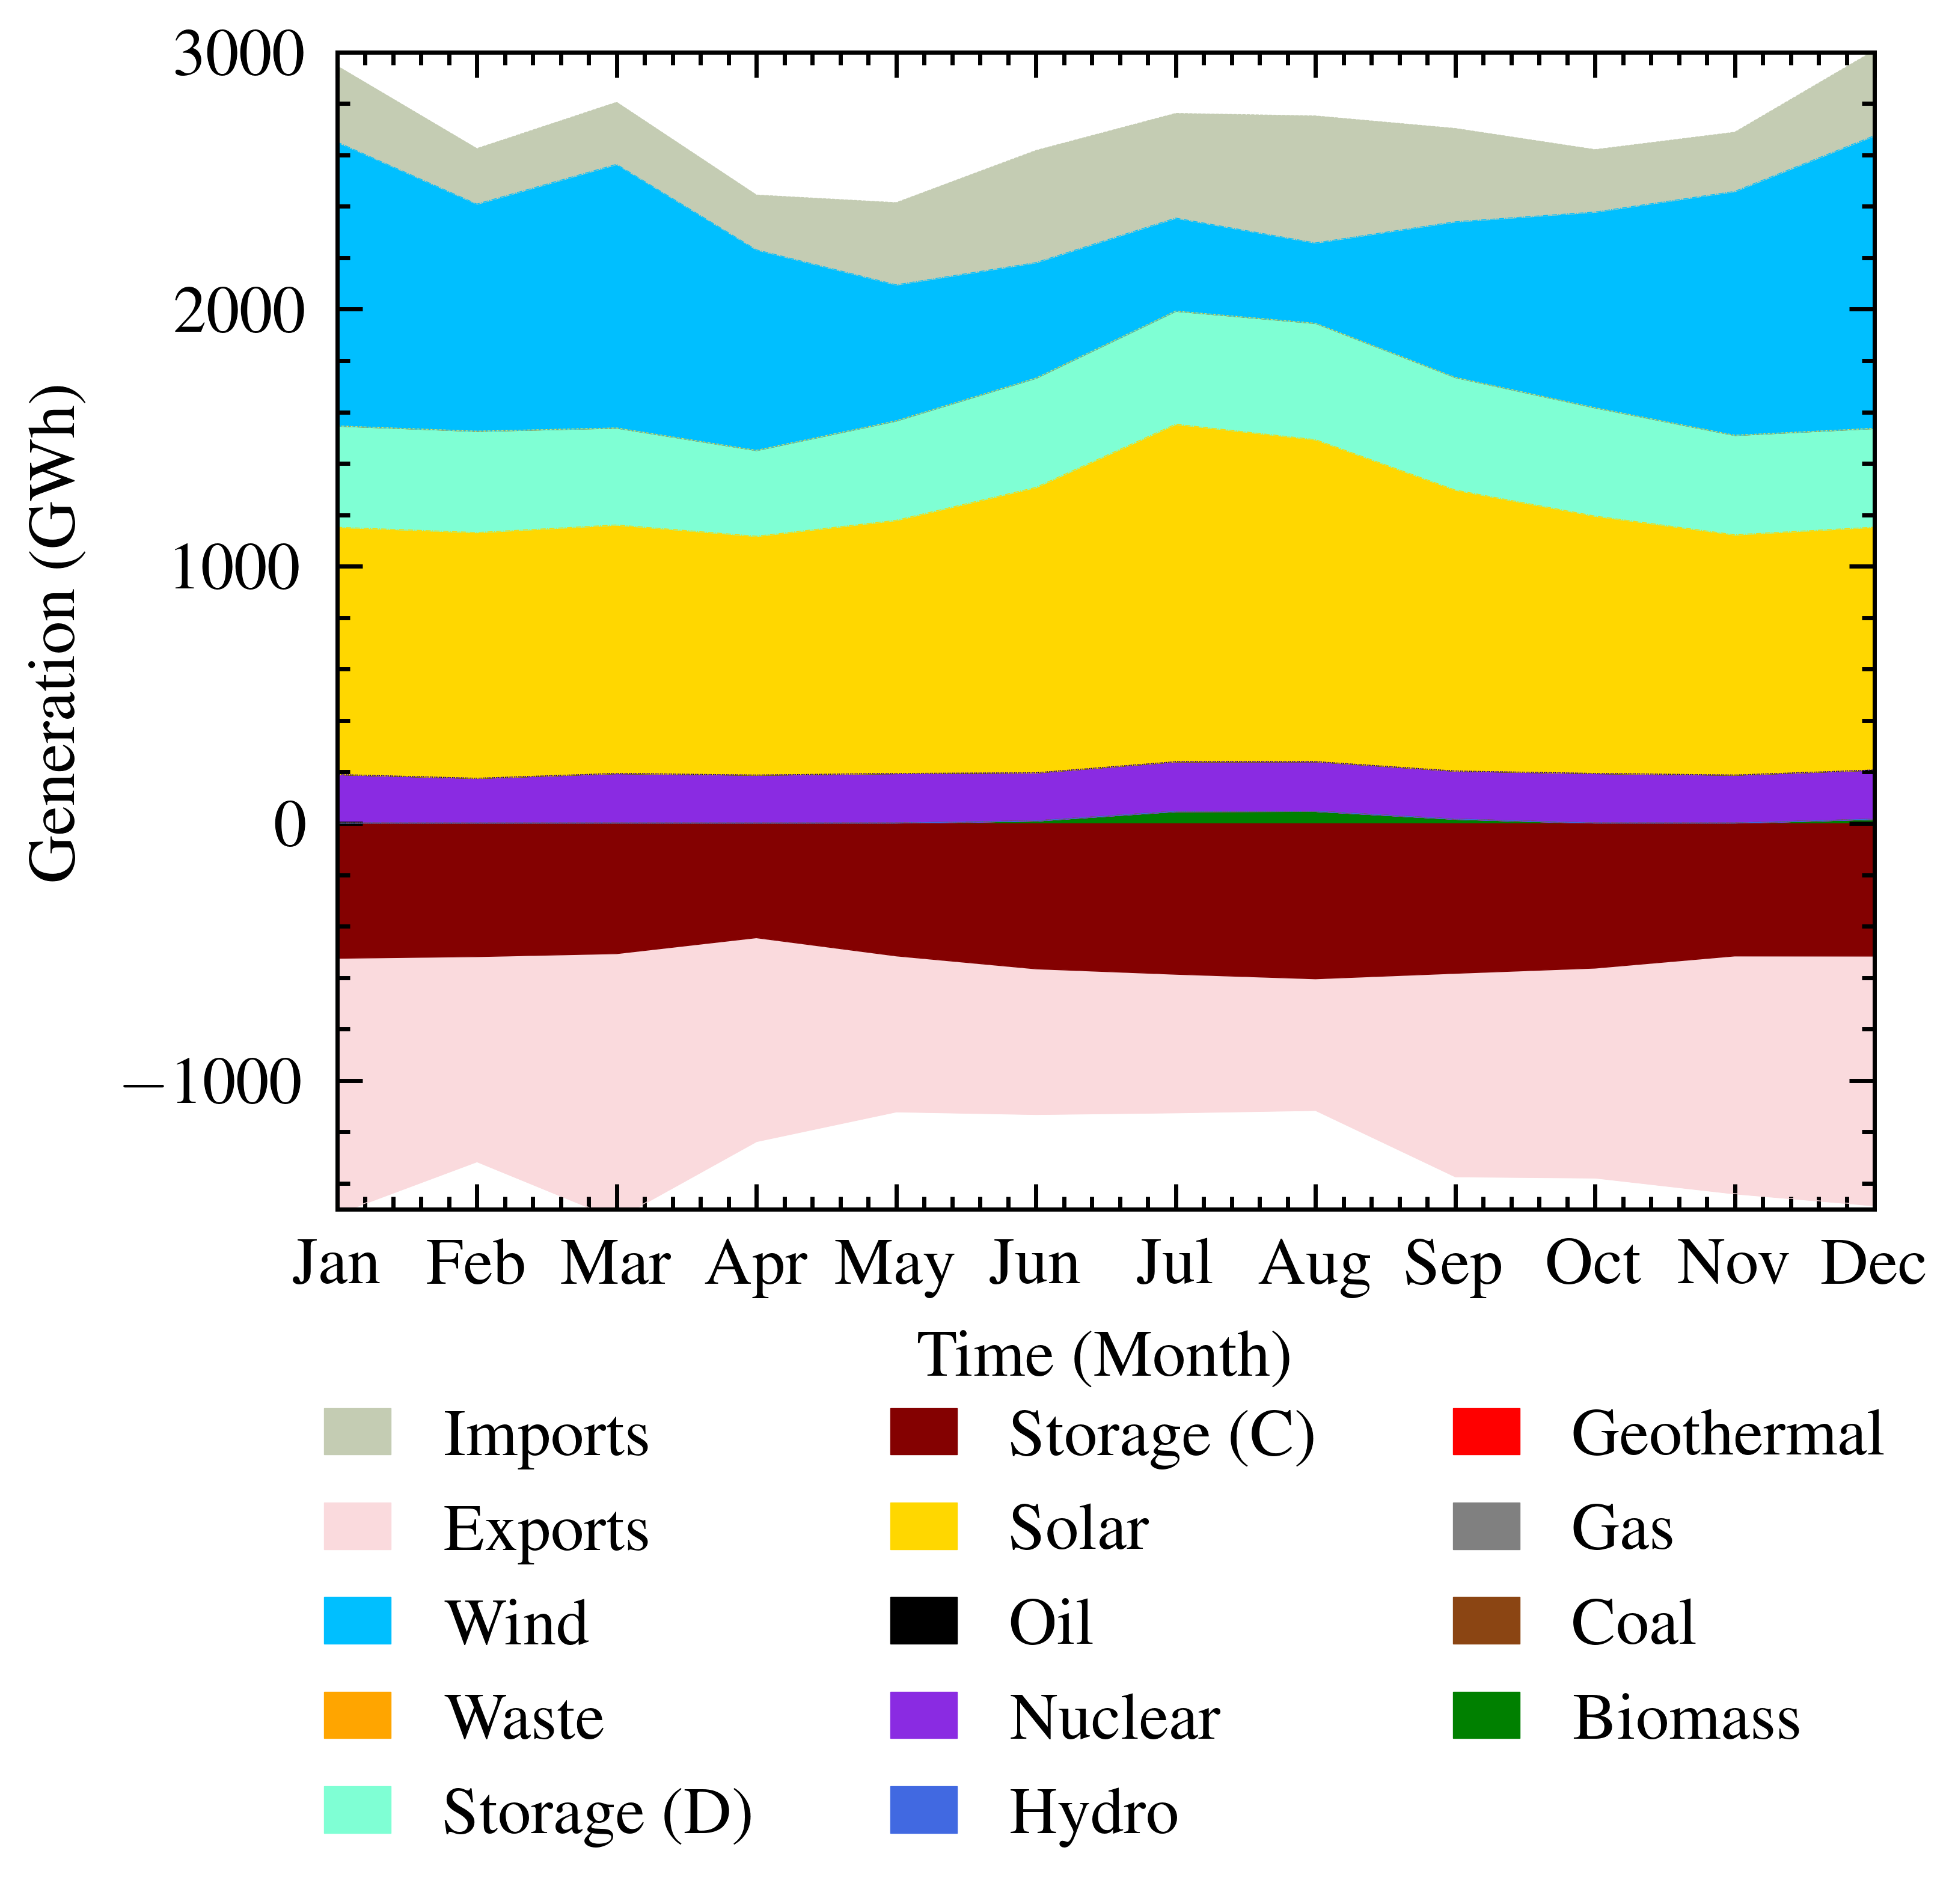

In [232]:
# Initialize figure environment
fig, ax = plt.subplots(dpi=1000)

# Main plot
ax = monthly_dispatch_source[tech_order].rename(index=month_dic).plot.area(stacked=True,ax=ax, color=tech_colors, rot=0, lw=0.1)

# Label configuration
plt.xlabel("Time (Month)")
plt.ylabel("Generation (GWh)")

handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1],
    labels[::-1],
    bbox_to_anchor=(0.5, -0.12),
    loc="upper center",
    ncol=3,
    handlelength=1,
    edgecolor="black",
    facecolor="white",
)
ax.set_ylim(-1500,3000)
ax.set_xlim(monthly_dispatch_source.index[0], monthly_dispatch_source.index[-2])
#ax.set_xlim(0, 24)
#Axis configuration
#ax.grid(axis='y', linestyle='dashed')

ax.set_xticks(np.linspace(0,11,12), m12_ticks,  rotation=0)
#Set background of the graph

plt.savefig(folder_to_save_results + str(sc) + " scenario monthly dispatch from " + str(time_1) + " to " + str(time_2) + " in "+ str(zone)  +".pdf" , transparent=False)